# GTZAN - Deep Learning

`Music Genre Classification Problem`. Experts have been trying for a long time to understand sound & what differentiates one from another. How to visualize sound. What makes one tone different from another.

We are going to analyze the features extracted from the GTZAN dataset and build different type of ensemble models to see how better we can differentiate one genre from another.

Our Datasets contains 10 genres:-
- Blues
- Classical
- Country
- Disco
- Hiphop
- Jazz
- Metal
- Pop
- Reggae
- Rock


# Reading & Understanding Data
## Importing Libraries

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import random
import librosa, IPython
import librosa.display as lplt
seed = 12
np.random.seed(seed)

### Loading Dataset

In [31]:
df = pd.read_csv('/kaggle/input/gtzan-dataset-music-genre-classification/Data/features_3_sec.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [32]:
# Display the first few rows to understand the structure
print(df.head())

# Drop any non-feature columns like 'filename' or 'label' if present
feature_columns = df.drop(['filename', 'label'], axis=1, errors='ignore')

# Find the input size (number of features per song)
input_size = feature_columns.shape[1]

print("Input size (number of features):", input_size)
print("Number of samples (total rows):", feature_columns.shape[0])

            filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.0.wav   66149          0.335406         0.091048  0.130405   
1  blues.00000.1.wav   66149          0.343065         0.086147  0.112699   
2  blues.00000.2.wav   66149          0.346815         0.092243  0.132003   
3  blues.00000.3.wav   66149          0.363639         0.086856  0.132565   
4  blues.00000.4.wav   66149          0.335579         0.088129  0.143289   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.003521             1773.065032          167541.630869   
1  0.001450             1816.693777           90525.690866   
2  0.004620             1788.539719          111407.437613   
3  0.002448             1655.289045          111952.284517   
4  0.001701             1630.656199           79667.267654   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              1972.744388           117335.771563  ...   39.687145   
1              2010.05

### About the dataset

In [33]:
print("Dataset has",df.shape)
print("Count of Positive and Negative samples")
df.label.value_counts().reset_index()

Dataset has (9990, 60)
Count of Positive and Negative samples


,index,label
0,jazz,1000
1,blues,1000
2,metal,1000
3,reggae,1000
4,pop,1000
5,disco,999
6,classical,998
7,rock,998
8,hiphop,998
9,country,997


# Data Visualization

In [34]:
audio_fp = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/blues/blues.00001.wav'
audio_data, sr = librosa.load(audio_fp)
audio_data, _ = librosa.effects.trim(audio_data)

In [35]:
# play sample file
IPython.display.Audio(audio_data, rate=sr)

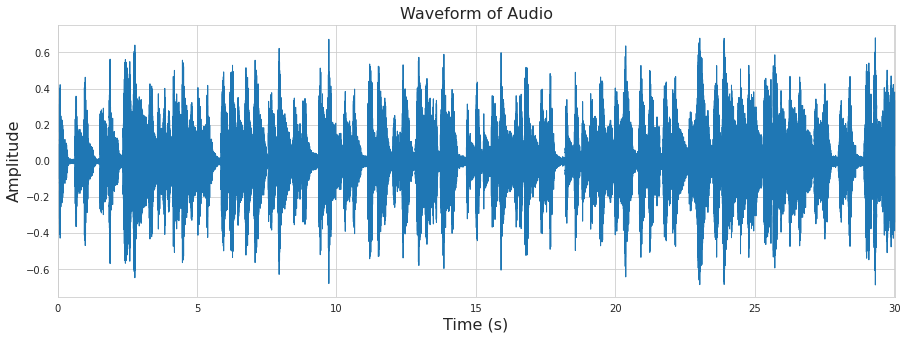

In [36]:
import librosa.display as lplt
import matplotlib.pyplot as plt

# Assuming audio_data contains the audio waveform data
plt.figure(figsize=(15, 5))
lplt.waveplot(audio_data, sr=sr)  # `sr` is the sample rate of the audio

# Labeling with increased font sizes
plt.xlabel("Time (s)", fontsize=16)  # Adjust x-axis label font size
plt.ylabel("Amplitude", fontsize=16)  # Adjust y-axis label font size
plt.title("Waveform of Audio", fontsize=16)  # Adjust title font size

plt.show()


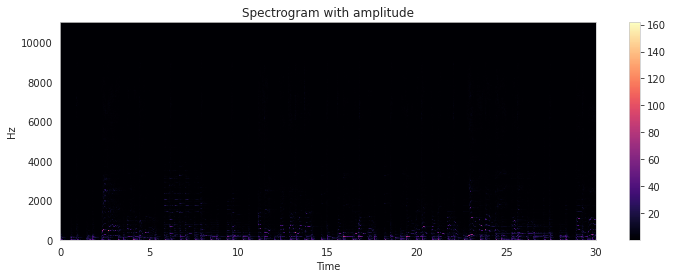

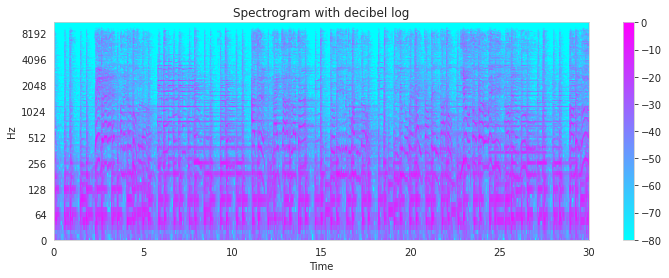

In [37]:
n_fft = 2048 # window size
hop_length = 512 # window hop length for STFT

stft = librosa.stft(audio_data, n_fft=n_fft, hop_length=hop_length)
stft_db = librosa.amplitude_to_db(stft, ref=np.max)

plt.figure(figsize=(12,4))
lplt.specshow(stft, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title("Spectrogram with amplitude")
plt.show()

plt.figure(figsize=(12,4))
lplt.specshow(stft_db, sr=sr, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.title("Spectrogram with decibel log")
plt.show()

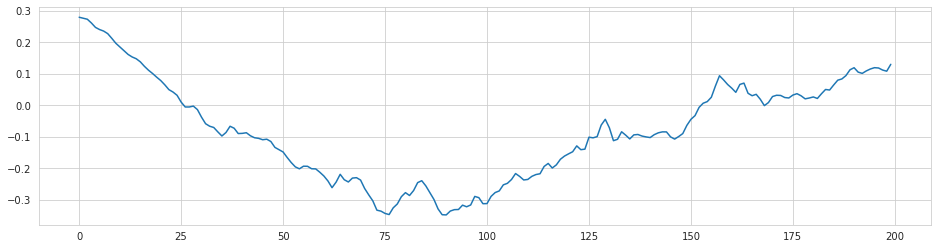

In [38]:
# plot zoomed audio wave 
start = 1000
end = 1200
plt.figure(figsize=(16,4))
plt.plot(audio_data[start:end])
plt.show()

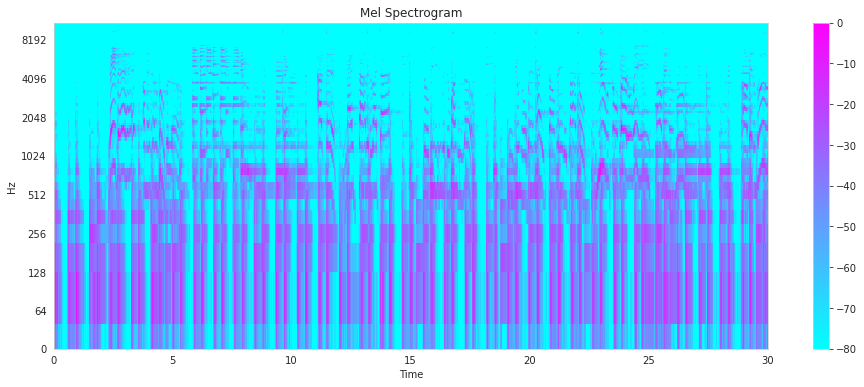

In [39]:
mel_spec = librosa.feature.melspectrogram(audio_data, sr=sr)
mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
plt.figure(figsize=(16,6))
lplt.specshow(mel_spec_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.title("Mel Spectrogram")
plt.show()

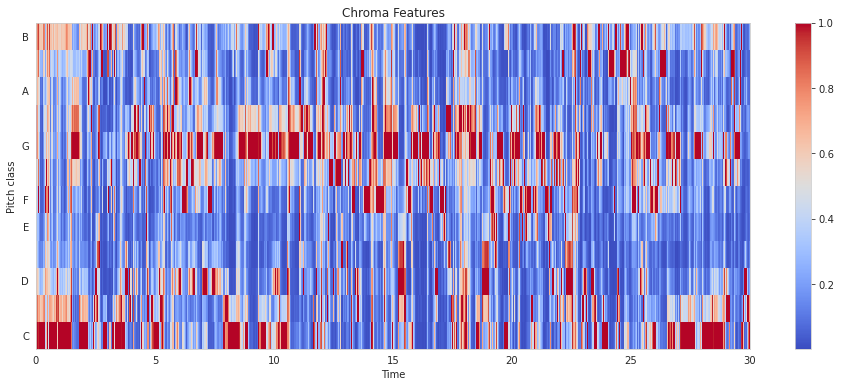

In [40]:
chroma = librosa.feature.chroma_stft(audio_data, sr=sr)
plt.figure(figsize=(16,6))
lplt.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.colorbar()
plt.title("Chroma Features")
plt.show()

In [16]:
# # Computing the Correlation Matrix
# spike_cols = [col for col in df.columns if 'mean' in col]
# corr = df[spike_cols].corr()

# # Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(corr, dtype=np.bool))

# # Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(16, 11));

# # Generate a custom diverging colormap
# cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})

# plt.title('Correlation Heatmap (for the MEAN variables)', fontsize = 20)
# plt.xticks(fontsize = 10)
# plt.yticks(fontsize = 10);
# plt.savefig("Corr_Heatmap.png")

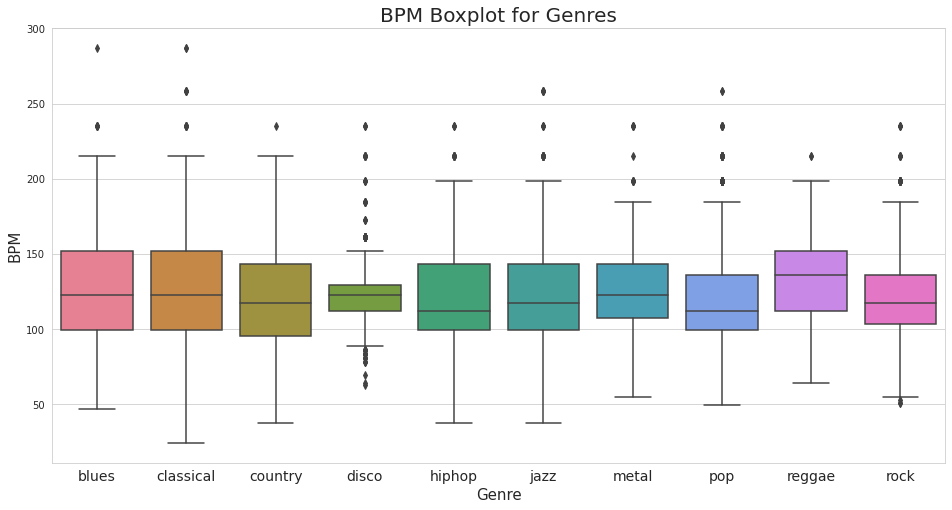

In [12]:
x = df[["label", "tempo"]]

fig, ax = plt.subplots(figsize=(16, 8));
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'husl');

plt.title('BPM Boxplot for Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)
plt.savefig("BPM_Boxplot.png")

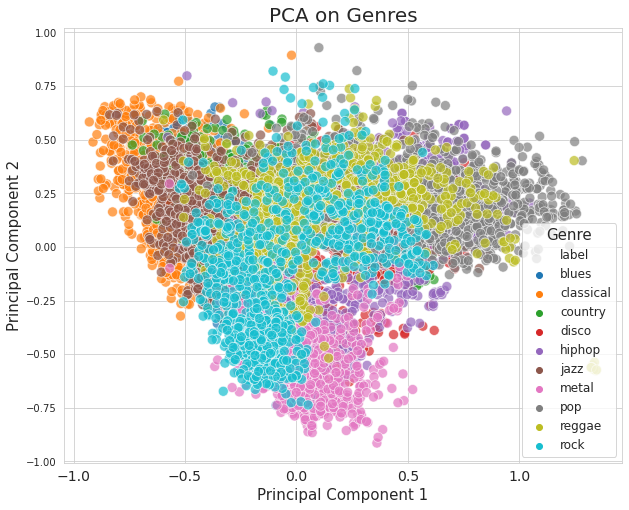

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import sklearn.preprocessing as skp

# Load data and preprocess
data = df.iloc[0:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']

# Scale data
cols = X.columns
min_max_scaler = skp.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns=cols)

# PCA transformation
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data=principalComponents, columns=['pc1', 'pc2'])

# Concatenate PCA components with labels
finalDf = pd.concat([principalDf, y], axis=1)

# Plotting
plt.figure(figsize=(10, 8))  # Reduce figure size while maintaining aspect ratio
sns.scatterplot(x="pc1", y="pc2", data=finalDf, hue="label", alpha=0.7, s=100)

# Set plot titles and labels
plt.title('PCA on Genres', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=10)
plt.xlabel("Principal Component 1", fontsize=15)
plt.ylabel("Principal Component 2", fontsize=15)

# Adjust legend font size
plt.legend(title="Genre", title_fontsize=15, fontsize=12)

# Save with high DPI for better quality
plt.show()


# Data Preparation

- Treat missing values.
- Outlier Treatment
- Define dummy variables for categorical variables.

## Missing Value Treatment

In [42]:
print("Columns with NA values are",list(df.columns[df.isnull().any()]))

Columns with NA values are []


`No null values in the dataset`



`There are no categorical variable as such. Hence, Dummy variable creation is not needed.`

## Encode Genre Label

In [45]:
label_index = dict()
index_label = dict()
for i, x in enumerate(df.label.unique()):
    label_index[x] = i
    index_label[i] = x
print(label_index)
print(index_label)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}


In [46]:
# update labels in df to index
df.label = [label_index[l] for l in df.label]

# Split Train, Dev & Test Sets

In [47]:
df_shuffle = df.sample(frac=1, random_state=seed).reset_index(drop=True)

In [48]:
df_shuffle.drop(['filename', 'length'], axis=1, inplace=True)
df_y = df_shuffle.pop('label')
df_X = df_shuffle

X_train, df_test_valid_X, y_train, df_test_valid_y = skms.train_test_split(df_X, df_y, train_size=0.7, random_state=seed, stratify=df_y)
X_dev, X_test, y_dev, y_test = skms.train_test_split(df_test_valid_X, df_test_valid_y, train_size=0.66, random_state=seed, stratify=df_test_valid_y)

In [49]:
print(f"Train set has {X_train.shape[0]} records out of {len(df_shuffle)} which is {round(X_train.shape[0]/len(df_shuffle)*100)}%")
print(f"Dev set has {X_dev.shape[0]} records out of {len(df_shuffle)} which is {round(X_dev.shape[0]/len(df_shuffle)*100)}%")
print(f"Test set has {X_test.shape[0]} records out of {len(df_shuffle)} which is {round(X_test.shape[0]/len(df_shuffle)*100)}%")

Train set has 6993 records out of 9990 which is 70%
Dev set has 1978 records out of 9990 which is 20%
Test set has 1019 records out of 9990 which is 10%


In [50]:
print("Unique classes present in training set: ",y_train.value_counts()[0]/y_train.shape[0]*100)
print("Unique classes present in validation set: ",y_dev.value_counts()[0]/y_dev.shape[0]*100)
print("Unique classes present in training set: ",y_test.value_counts()[0]/y_test.shape[0]*100)

Unique classes present in training set:  10.01001001001001
Unique classes present in validation set:  10.010111223458038
Unique classes present in training set:  10.009813542688912


## Scale the Features

In [51]:
scaler = skp.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_dev = pd.DataFrame(scaler.transform(X_dev), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

# Model Building

In [52]:
import tensorflow as tf
print("TF version:-", tf.__version__)
import keras as k
tf.random.set_seed(seed)

TF version:- 2.3.1


In [20]:
ACCURACY_THRESHOLD = 0.94

class myCallback(k.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > ACCURACY_THRESHOLD):
            print("\n\nStopping training as we have reached %2.2f%% accuracy!" %(ACCURACY_THRESHOLD*100))   
            self.model.stop_training = True

def trainModel(model, epochs, optimizer):
    batch_size = 128
    callback = myCallback()
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics='accuracy'
    )
    return model.fit(X_train, y_train, validation_data=(X_dev, y_dev), epochs=epochs, 
                     batch_size=batch_size, callbacks=[callback])

def plotHistory(history):
    print("Max. Validation Accuracy",max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=(12,6))
    plt.show()


In [32]:
model_1 = k.models.Sequential([
    k.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dense(128, activation='relu'),
    k.layers.Dense(64, activation='relu'),
    k.layers.Dense(10, activation='softmax'),
])
print(model_1.summary())
model_1_history = trainModel(model=model_1, epochs=70, optimizer='adam')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 256)               14848     
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 10)                650       
Total params: 56,650
Trainable params: 56,650
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/70
55/55 [==============================] - 0s 7ms/step - loss: 1.4769 - accuracy: 0.4915 - val_loss: 1.0643 - val_accuracy: 0.6385
Epoch 2/70
55/55 [==============================] - 0s 3ms/step - loss: 0.9042 - accuracy: 0.6968 - val

KeyboardInterrupt: 

Max. Validation Accuracy 0.8988877534866333


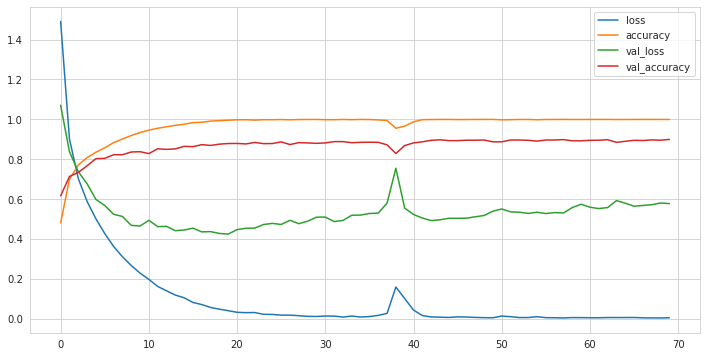

In [40]:
plotHistory(model_1_history)

In [26]:
model_2 = k.models.Sequential([
    k.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(0.2),
    
    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(10, activation='softmax'),
])
print(model_2.summary())
model_2_history = trainModel(model=model_2, epochs=100, optimizer='adam')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               29696     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)               

Max. Validation Accuracy 0.930738091468811


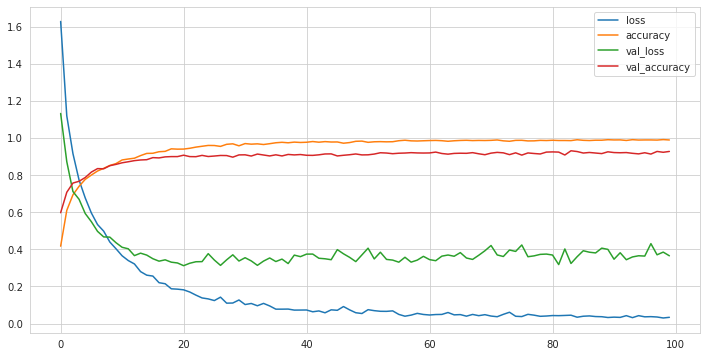

In [27]:
plotHistory(model_2_history)

In [28]:
model_3 = k.models.Sequential([
    k.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(0.2),
    
    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(10, activation='softmax'),
])
print(model_3.summary())
model_3_history = trainModel(model=model_3, epochs=700, optimizer='sgd')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               29696     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)               

Max. Validation Accuracy 0.9186046719551086


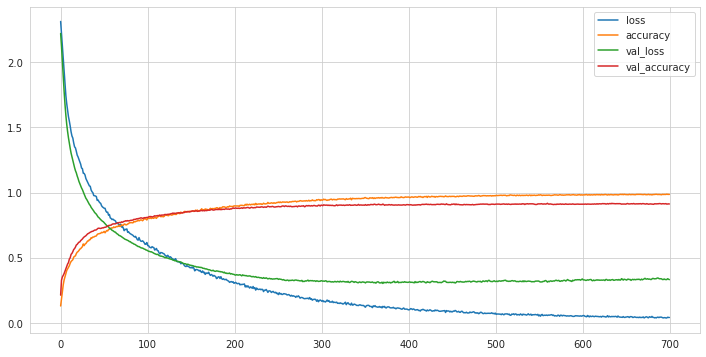

In [29]:
plotHistory(model_3_history)

In [42]:
model_4 = k.models.Sequential([
    k.layers.Dense(1024, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(0.3),
    
    k.layers.Dense(512, activation='relu'),
    k.layers.Dropout(0.3),

    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(0.3),

    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(0.3),

    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.3),
    
    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.3),
    
    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.3),

    k.layers.Dense(10, activation='softmax'),
])
print(model_4.summary())
model_4_history = trainModel(model=model_4, epochs=500, optimizer='rmsprop')

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 1024)              59392     
_________________________________________________________________
dropout_18 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_19 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_20 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 128)              

Max. Validation Accuracy 0.9393326640129089


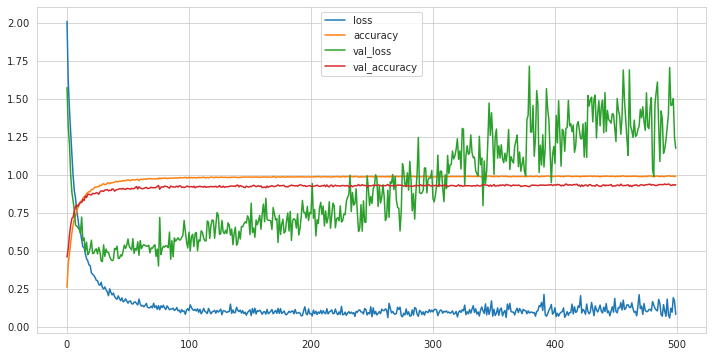

In [43]:
plotHistory(model_4_history)

In [ ]:
test_loss, test_acc  = model_4.evaluate(X_test, y_test, batch_size=128)
print("The test Loss is :",test_loss)
print("\nThe Best test Accuracy is :",test_acc*100)

**Sequential model with bidirectional LSTMs and increased dropout rates**

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              59392     
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
reshape (Reshape)            (None, 1, 512)            0

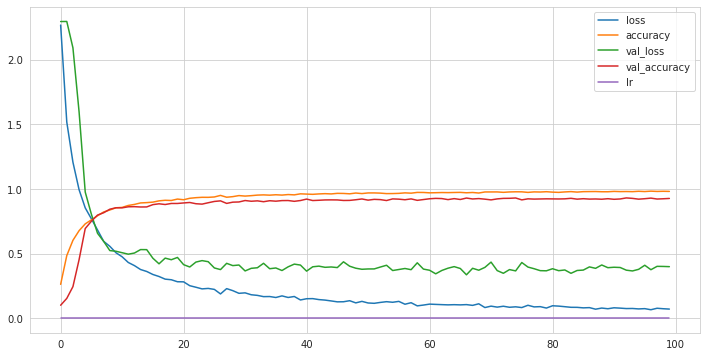

In [35]:
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import LearningRateScheduler

# Learning rate schedule function
def lr_schedule(epoch, lr):
    if epoch > 100:
        lr = lr * 0.1
    return lr

# Model Definition
model_4 = Sequential([
    
    # First Dense block with Batch Normalization
    Dense(1024, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    
    # Second Dense block with Batch Normalization
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Reshape layer to feed into LSTM (adding a timesteps dimension)
    Reshape((1, 512)),  # Reshape to (timesteps=1, features=512)

    # LSTM layers
    LSTM(64, return_sequences=True),
    BatchNormalization(),  # Normalization after LSTM
    LSTM(64, return_sequences=False),
    BatchNormalization(),

    # Dense blocks after LSTM layers with Batch Normalization
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Output layer with softmax for classification
    Dense(10, activation='softmax'),
])

# Print the model summary
print(model_4.summary())

# Custom callback to stop training if accuracy threshold is reached
ACCURACY_THRESHOLD = 0.94
class myCallback(k.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > ACCURACY_THRESHOLD):
            print("\n\nStopping training as we have reached %2.2f%% accuracy!" % (ACCURACY_THRESHOLD*100))   
            self.model.stop_training = True

# Compile the model
callback = myCallback()
lr_scheduler = LearningRateScheduler(lr_schedule)

def trainModel(model, epochs, optimizer):
    batch_size = 128
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model.fit(X_train, y_train, validation_data=(X_dev, y_dev), 
                     epochs=epochs, batch_size=batch_size, callbacks=[callback, lr_scheduler])

# Train the model
model_4_history = trainModel(model=model_4, epochs=100, optimizer='rmsprop')

# Evaluate the model on the test set
test_loss, test_acc = model_4.evaluate(X_test, y_test, batch_size=128)
print("The test Loss is:", test_loss)
print("The Best test Accuracy is:", test_acc * 100)

# Plot training history
def plotHistory(history):
    print("Max. Validation Accuracy:", max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=(12, 6))
    plt.show()

plotHistory(model_4_history)


# Model Evaluation

Train set has 6993 records out of 9990 which is 70%
Dev set has 1978 records out of 9990 which is 20%
Test set has 1019 records out of 9990 which is 10%
10.01001001001001
10.010111223458038
10.009813542688912
Epoch 1/100
55/55 [==============================] - 14s 259ms/step - loss: 2.2341 - accuracy: 0.1750 - val_loss: 2.2693 - val_accuracy: 0.1370
Epoch 2/100
55/55 [==============================] - 13s 234ms/step - loss: 1.9616 - accuracy: 0.2640 - val_loss: 2.0398 - val_accuracy: 0.2927
Epoch 3/100
55/55 [==============================] - 13s 244ms/step - loss: 1.8566 - accuracy: 0.3003 - val_loss: 1.9630 - val_accuracy: 0.3023
Epoch 4/100
55/55 [==============================] - 13s 232ms/step - loss: 1.8187 - accuracy: 0.3302 - val_loss: 1.9181 - val_accuracy: 0.2826
Epoch 5/100
55/55 [==============================] - 13s 240ms/step - loss: 1.7782 - accuracy: 0.3418 - val_loss: 1.8810 - val_accuracy: 0.3215
Epoch 6/100
55/55 [==============================] - 13s 231ms/step - l

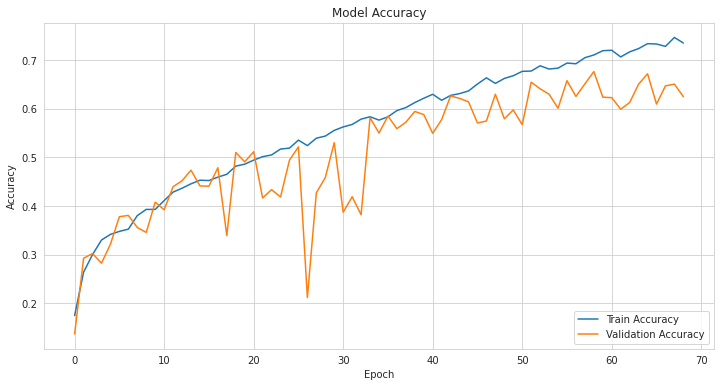

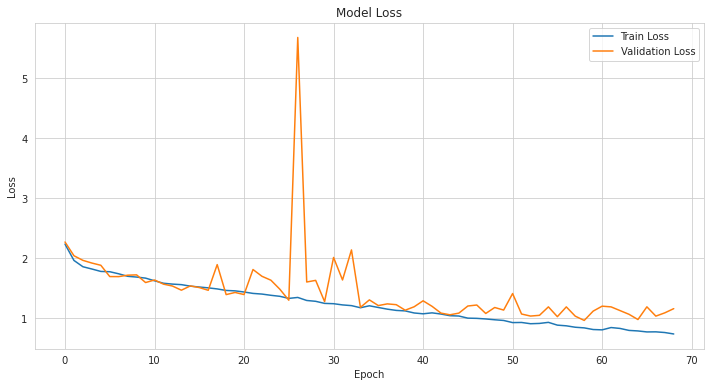

In [34]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import LSTM, BatchNormalization, Dropout, Dense, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import sklearn.preprocessing as skp

# Print data statistics
print(f"Train set has {X_train.shape[0]} records out of {len(df_shuffle)} which is {round(X_train.shape[0]/len(df_shuffle)*100)}%")
print(f"Dev set has {X_dev.shape[0]} records out of {len(df_shuffle)} which is {round(X_dev.shape[0]/len(df_shuffle)*100)}%")
print(f"Test set has {X_test.shape[0]} records out of {len(df_shuffle)} which is {round(X_test.shape[0]/len(df_shuffle)*100)}%")
print(y_train.value_counts()[0]/y_train.shape[0]*100)
print(y_dev.value_counts()[0]/y_dev.shape[0]*100)
print(y_test.value_counts()[0]/y_test.shape[0]*100)

X_train_np = X_train.values
X_dev_np = X_dev.values
X_test_np = X_test.values

# Flatten the data for scaling (samples, time_steps * features)
X_train_flattened = X_train_np.reshape(X_train_np.shape[0], -1)
X_dev_flattened = X_dev_np.reshape(X_dev_np.shape[0], -1)
X_test_flattened = X_test_np.reshape(X_test_np.shape[0], -1)

# Standardize the data
scaler = skp.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flattened)
X_dev_scaled = scaler.transform(X_dev_flattened)
X_test_scaled = scaler.transform(X_test_flattened)

# Reshape back to 3D (samples, time_steps, features)
X_train = X_train_scaled.reshape(X_train_np.shape[0], 57, 1)  # Change '57' to the correct number of time steps if needed
X_dev = X_dev_scaled.reshape(X_dev_np.shape[0], 57, 1)
X_test = X_test_scaled.reshape(X_test_np.shape[0], 57, 1)

# Parallel LSTM model with two input branches
def create_parallel_model(input_shape):
    # First Branch
    branch1_input = Input(shape=input_shape)
    x1 = LSTM(128, return_sequences=True)(branch1_input)
    x1 = BatchNormalization()(x1)
    x1 = LSTM(64, return_sequences=False)(x1)
    x1 = BatchNormalization()(x1)
    x1 = Dropout(0.3)(x1)
    branch1_output = Dense(64, activation="relu")(x1)

    # Second Branch
    branch2_input = Input(shape=input_shape)
    x2 = LSTM(128, return_sequences=True)(branch2_input)
    x2 = BatchNormalization()(x2)
    x2 = LSTM(64, return_sequences=False)(x2)
    x2 = BatchNormalization()(x2)
    x2 = Dropout(0.3)(x2)
    branch2_output = Dense(64, activation="relu")(x2)

    # Combine the branches
    combined = Concatenate()([branch1_output, branch2_output])

    # Fully connected layer
    z = Dense(128, activation="relu")(combined)
    z = Dropout(0.4)(z)
    z = Dense(64, activation="relu")(z)
    z = Dropout(0.4)(z)
    z = Dense(10, activation="softmax")(z)  # Assuming 10-class classification

    # Model with two inputs
    model = models.Model(inputs=[branch1_input, branch2_input], outputs=z)

    return model

# Create the model
input_shape = (57, 1)  # Adjust this to your actual input shape
parallel_lstm_model = create_parallel_model(input_shape)

# Compile the model
parallel_lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the model
history = parallel_lstm_model.fit([X_train, X_train], y_train,  # Using X_train for both branches
                                  epochs=100, 
                                  batch_size=128, 
                                  validation_data=([X_dev, X_dev], y_dev),  # Using X_dev for both branches
                                  callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_acc = parallel_lstm_model.evaluate([X_test, X_test], y_test, batch_size=128)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

# Plot training & validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


Train set has 6993 records out of 9990 which is 70%
Dev set has 1978 records out of 9990 which is 20%
Test set has 1019 records out of 9990 which is 10%
10.01001001001001
10.010111223458038
10.009813542688912
Epoch 1/50
110/110 [==============================] - 5s 49ms/step - loss: 1.8167 - accuracy: 0.3852 - val_loss: 2.3751 - val_accuracy: 0.1694
Epoch 2/50
110/110 [==============================] - 5s 46ms/step - loss: 1.2524 - accuracy: 0.5694 - val_loss: 2.8626 - val_accuracy: 0.2063
Epoch 3/50
110/110 [==============================] - 5s 46ms/step - loss: 0.9902 - accuracy: 0.6662 - val_loss: 1.9085 - val_accuracy: 0.4105
Epoch 4/50
110/110 [==============================] - 5s 46ms/step - loss: 0.7806 - accuracy: 0.7405 - val_loss: 0.9763 - val_accuracy: 0.6719
Epoch 5/50
110/110 [==============================] - 5s 46ms/step - loss: 0.6170 - accuracy: 0.7955 - val_loss: 0.6002 - val_accuracy: 0.8099
Epoch 6/50
110/110 [==============================] - 6s 51ms/step - loss: 0

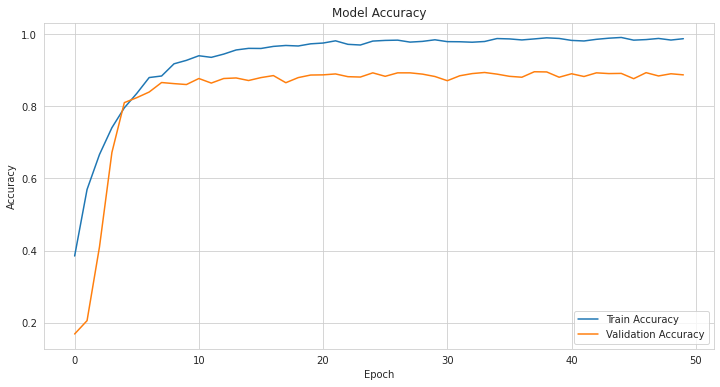

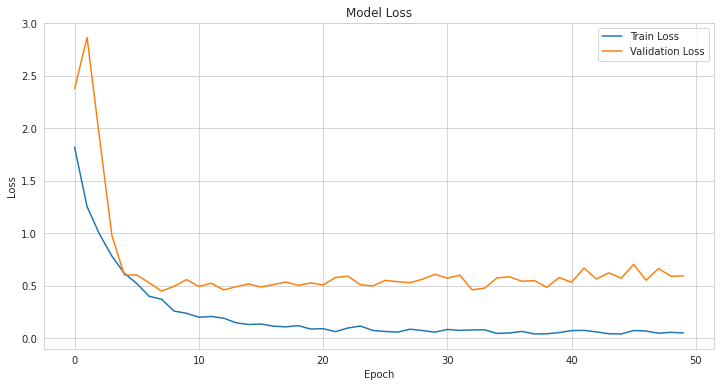

In [36]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Dropout, Dense, Input, Concatenate, Flatten
import matplotlib.pyplot as plt
import sklearn.preprocessing as skp

# Print data statistics
print(f"Train set has {X_train.shape[0]} records out of {len(df_shuffle)} which is {round(X_train.shape[0]/len(df_shuffle)*100)}%")
print(f"Dev set has {X_dev.shape[0]} records out of {len(df_shuffle)} which is {round(X_dev.shape[0]/len(df_shuffle)*100)}%")
print(f"Test set has {X_test.shape[0]} records out of {len(df_shuffle)} which is {round(X_test.shape[0]/len(df_shuffle)*100)}%")
print(y_train.value_counts()[0]/y_train.shape[0]*100)
print(y_dev.value_counts()[0]/y_dev.shape[0]*100)
print(y_test.value_counts()[0]/y_test.shape[0]*100)

# Flatten the data for scaling (samples, time_steps * features)
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_dev_flattened = X_dev.reshape(X_dev.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

# Standardize the data
scaler = skp.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flattened)
X_dev_scaled = scaler.transform(X_dev_flattened)
X_test_scaled = scaler.transform(X_test_flattened)

# Reshape back to 3D (samples, time_steps, features)
X_train = X_train_scaled.reshape(X_train.shape[0], 57, 1)
X_dev = X_dev_scaled.reshape(X_dev.shape[0], 57, 1)
X_test = X_test_scaled.reshape(X_test.shape[0], 57, 1)

# Parallel CNN model with two input branches
def create_parallel_model(input_shape):
    # First Branch
    branch1_input = Input(shape=input_shape)
    x1 = Conv1D(64, kernel_size=5, activation='relu', padding='same')(branch1_input)
    x1 = BatchNormalization()(x1)
    x1 = MaxPooling1D(pool_size=2)(x1)
    x1 = Conv1D(128, kernel_size=5, activation='relu', padding='same')(x1)
    x1 = BatchNormalization()(x1)
    x1 = MaxPooling1D(pool_size=2)(x1)
    x1 = Conv1D(256, kernel_size=5, activation='relu', padding='same')(x1)
    x1 = BatchNormalization()(x1)
    x1 = MaxPooling1D(pool_size=2)(x1)
    x1 = Flatten()(x1)
    x1 = Dense(128, activation="relu")(x1)
    x1 = Dropout(0.3)(x1)

    # Second Branch
    branch2_input = Input(shape=input_shape)
    y2 = Conv1D(64, kernel_size=5, activation='relu', padding='same')(branch2_input)
    y2 = BatchNormalization()(y2)
    y2 = MaxPooling1D(pool_size=2)(y2)
    y2 = Conv1D(128, kernel_size=5, activation='relu', padding='same')(y2)
    y2 = BatchNormalization()(y2)
    y2 = MaxPooling1D(pool_size=2)(y2)
    y2 = Conv1D(256, kernel_size=5, activation='relu', padding='same')(y2)
    y2 = BatchNormalization()(y2)
    y2 = MaxPooling1D(pool_size=2)(y2)
    y2 = Flatten()(y2)
    y2 = Dense(128, activation="relu")(y2)
    y2 = Dropout(0.3)(y2)

    # Combine the branches
    combined = Concatenate()([x1, y2])

    # Fully connected layer
    z = Dense(256, activation="relu")(combined)
    z = Dropout(0.4)(z)
    z = Dense(128, activation="relu")(z)
    z = Dropout(0.4)(z)
    z = Dense(10, activation="softmax")(z)  # Assuming 10-class classification

    # Model with two inputs
    model = models.Model(inputs=[branch1_input, branch2_input], outputs=z)

    return model

# Create the model
input_shape = (57, 1)  # Adjust this to your actual input shape
parallel_cnn_model = create_parallel_model(input_shape)

# Compile the model
parallel_cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Training the model without early stopping
history = parallel_cnn_model.fit([X_train, X_train], y_train,  # Using X_train for both branches
                                  epochs=50,  # Run for 50 epochs
                                  batch_size=64,  # Smaller batch size for better gradient updates
                                  validation_data=([X_dev, X_dev], y_dev))  # Using X_dev for both branches

# Evaluate the model on the test set
test_loss, test_acc = parallel_cnn_model.evaluate([X_test, X_test], y_test, batch_size=64)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

# Plot training & validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


In [55]:
from tensorflow.keras.layers import LSTM

# Parallel CNN model with two input branches
def create_parallel_model(input_shape):
    # First Branch
    branch1_input = Input(shape=input_shape)
    x1 = Conv1D(64, kernel_size=5, activation='relu', padding='same')(branch1_input)
    x1 = MaxPooling1D(pool_size=2)(x1)
    x1 = Conv1D(128, kernel_size=5, activation='relu', padding='same')(x1)
    x1 = MaxPooling1D(pool_size=2)(x1)
    x1 = Conv1D(256, kernel_size=5, activation='relu', padding='same')(x1)
    x1 = MaxPooling1D(pool_size=2)(x1)
    
    # Second Branch
    branch2_input = Input(shape=input_shape)
    y2 = Conv1D(64, kernel_size=5, activation='relu', padding='same')(branch2_input)
    y2 = MaxPooling1D(pool_size=2)(y2)
    y2 = Conv1D(128, kernel_size=5, activation='relu', padding='same')(y2)
    y2 = MaxPooling1D(pool_size=2)(y2)
    y2 = Conv1D(256, kernel_size=5, activation='relu', padding='same')(y2)
    y2 = MaxPooling1D(pool_size=2)(y2)
    
    # Combine the branches
    combined = Concatenate()([x1, y2])
    
    # Add LSTM layer after concatenation
    z = LSTM(128, return_sequences=False, activation='tanh')(combined)

    # Final output layer for classification
    z = Dense(10, activation="softmax")(z)  # Assuming 10-class classification

    # Model with two inputs
    model = models.Model(inputs=[branch1_input, branch2_input], outputs=z)

    return model

# Create the model
input_shape = (57, 1)  # Adjust this to your actual input shape
parallel_cnn_lstm_model = create_parallel_model(input_shape)

# Compile the model
parallel_cnn_lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the model
history = parallel_cnn_lstm_model.fit([X_train, X_train], y_train,  # Using X_train for both branches
                                      epochs=100,  # 100 epochs
                                      batch_size=64,  # Smaller batch size for better gradient updates
                                      validation_data=([X_dev, X_dev], y_dev))  # Using X_dev for both branches

# Evaluate the model on the test set
test_loss, test_acc = parallel_cnn_lstm_model.evaluate([X_test, X_test], y_test, batch_size=64)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

Epoch 1/100
110/110 [==============================] - 7s 65ms/step - loss: 1.7186 - accuracy: 0.3539 - val_loss: 1.4359 - val_accuracy: 0.4798
Epoch 2/100
110/110 [==============================] - 7s 63ms/step - loss: 1.3632 - accuracy: 0.5061 - val_loss: 1.2350 - val_accuracy: 0.5495
Epoch 3/100
110/110 [==============================] - 7s 63ms/step - loss: 1.1196 - accuracy: 0.6095 - val_loss: 1.0328 - val_accuracy: 0.6223
Epoch 4/100
110/110 [==============================] - 7s 60ms/step - loss: 0.9106 - accuracy: 0.6831 - val_loss: 1.0043 - val_accuracy: 0.6643
Epoch 5/100
110/110 [==============================] - 7s 59ms/step - loss: 0.7466 - accuracy: 0.7429 - val_loss: 0.8372 - val_accuracy: 0.7042
Epoch 6/100
110/110 [==============================] - 7s 60ms/step - loss: 0.5969 - accuracy: 0.7964 - val_loss: 0.7592 - val_accuracy: 0.7427
Epoch 7/100
110/110 [==============================] - 7s 64ms/step - loss: 0.4666 - accuracy: 0.8441 - val_loss: 0.7255 - val_accuracy:

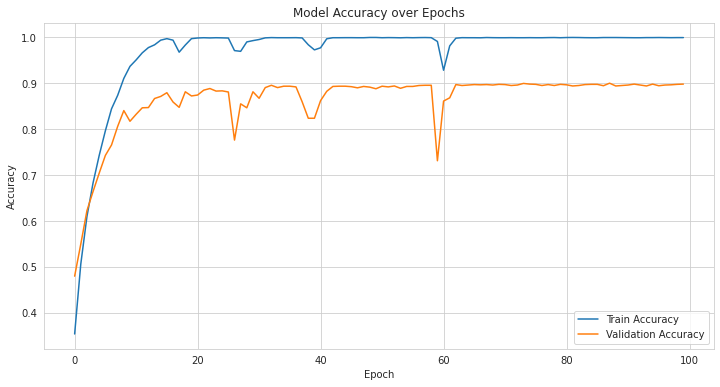

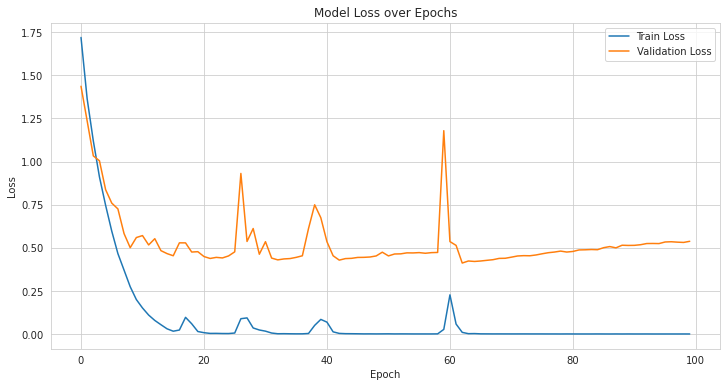

In [56]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


In [ ]:
Parallel CNN-LSTM Model:

****parallel CNN-LSTM Model:****


Epoch 1/100
110/110 [==============================] - 10s 88ms/step - loss: 1.3916 - accuracy: 0.5038 - val_loss: 2.8905 - val_accuracy: 0.1178
Epoch 2/100
110/110 [==============================] - 9s 84ms/step - loss: 0.9038 - accuracy: 0.6903 - val_loss: 2.2370 - val_accuracy: 0.2649
Epoch 3/100
110/110 [==============================] - 9s 80ms/step - loss: 0.6555 - accuracy: 0.7854 - val_loss: 1.3059 - val_accuracy: 0.5233
Epoch 4/100
110/110 [==============================] - 9s 80ms/step - loss: 0.4764 - accuracy: 0.8453 - val_loss: 0.8387 - val_accuracy: 0.7078
Epoch 5/100
110/110 [==============================] - 9s 81ms/step - loss: 0.3302 - accuracy: 0.8995 - val_loss: 0.8771 - val_accuracy: 0.7068
Epoch 6/100
110/110 [==============================] - 9s 85ms/step - loss: 0.2465 - accuracy: 0.9275 - val_loss: 0.9177 - val_accuracy: 0.7113
Epoch 7/100
110/110 [==============================] - 9s 81ms/step - loss: 0.1543 - accuracy: 0.9568 - val_loss: 0.4740 - val_accuracy

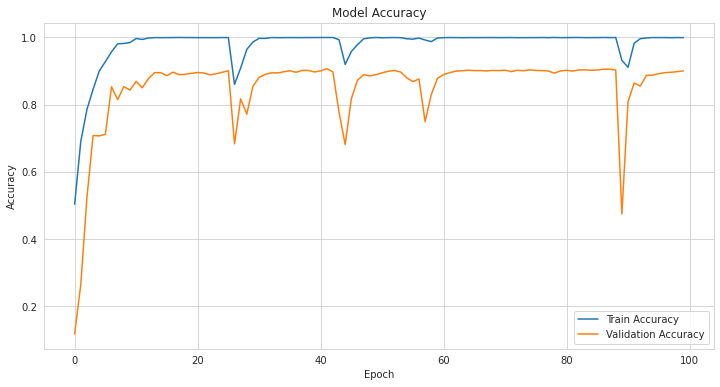

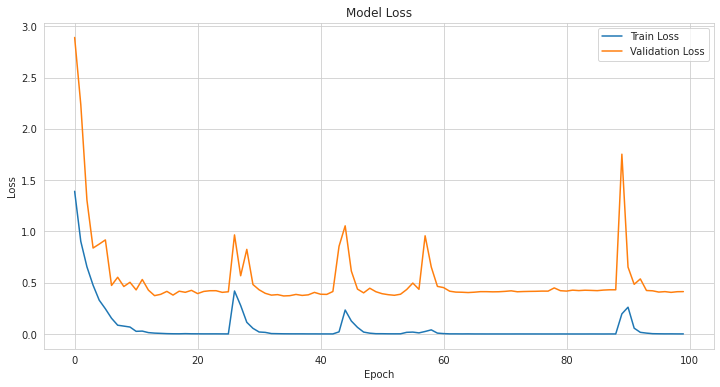

In [37]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, LSTM, Dense, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import sklearn.preprocessing as skp

# Assuming data preprocessing is already done as in your previous example
input_shape = (57,1)  # Use the input shape as per the provided snippet

# Create the parallel CNN model with LSTM and BatchNormalization
def create_parallel_model(input_shape):
    # First Branch
    branch1_input = Input(shape=input_shape)
    x1 = Conv1D(64, kernel_size=5, padding='same')(branch1_input)
    x1 = BatchNormalization()(x1)
    x1 = layers.Activation('relu')(x1)
    x1 = MaxPooling1D(pool_size=2)(x1)
    
    x1 = Conv1D(128, kernel_size=5, padding='same')(x1)
    x1 = BatchNormalization()(x1)
    x1 = layers.Activation('relu')(x1)
    x1 = MaxPooling1D(pool_size=2)(x1)
    
    x1 = Conv1D(256, kernel_size=5, padding='same')(x1)
    x1 = BatchNormalization()(x1)
    x1 = layers.Activation('relu')(x1)
    x1 = MaxPooling1D(pool_size=2)(x1)

    # Second Branch
    branch2_input = Input(shape=input_shape)
    y2 = Conv1D(64, kernel_size=5, padding='same')(branch2_input)
    y2 = BatchNormalization()(y2)
    y2 = layers.Activation('relu')(y2)
    y2 = MaxPooling1D(pool_size=2)(y2)
    
    y2 = Conv1D(128, kernel_size=5, padding='same')(y2)
    y2 = BatchNormalization()(y2)
    y2 = layers.Activation('relu')(y2)
    y2 = MaxPooling1D(pool_size=2)(y2)
    
    y2 = Conv1D(256, kernel_size=5, padding='same')(y2)
    y2 = BatchNormalization()(y2)
    y2 = layers.Activation('relu')(y2)
    y2 = MaxPooling1D(pool_size=2)(y2)
    
    # Combine the branches
    combined = Concatenate()([x1, y2])
    
    # Add LSTM layer after concatenation
    z = LSTM(128, return_sequences=False, activation='tanh')(combined)

    # Final output layer for classification
    z = Dense(10, activation="softmax")(z)  # Assuming 10-class classification

    # Model with two inputs
    model = models.Model(inputs=[branch1_input, branch2_input], outputs=z)

    return model

# Create the model using the input shape from the provided snippet
model = create_parallel_model(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit([X_train, X_train], y_train,  # Using X_train for both branches
                    epochs=100,  # 100 epochs
                    batch_size=64,  # Smaller batch size for better gradient updates
                    validation_data=([X_dev, X_dev], y_dev)  # Using X_dev for both branches
                   )
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate([X_test, X_test], y_test, batch_size=64)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

# Plot training & validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


****CNN-LSTM with Attention****

In [38]:
import tensorflow as tf
from tensorflow.keras import models, layers, Input, callbacks
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, BatchNormalization, Activation, Concatenate, Dropout

# Custom attention layer
class AttentionLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]),
                                 initializer="glorot_uniform",
                                 trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],),
                                 initializer="zeros",
                                 trainable=True)
        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer="glorot_uniform",
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        uit = tf.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        ait = tf.tensordot(uit, self.u, axes=1)
        ait = tf.nn.softmax(ait, axis=1)
        weighted_input = x * tf.expand_dims(ait, -1)
        return tf.reduce_sum(weighted_input, axis=1)

# CNN-LSTM with Attention for Audio Data
def create_parallel_model_with_attention(input_shape):
    # First Branch
    branch1_input = Input(shape=input_shape)
    x1 = Conv1D(64, kernel_size=5, padding='same')(branch1_input)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = MaxPooling1D(pool_size=2)(x1)
    x1 = Dropout(0.3)(x1)  # Dropout for regularization
    
    x1 = Conv1D(128, kernel_size=5, padding='same')(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = MaxPooling1D(pool_size=2)(x1)
    x1 = Dropout(0.3)(x1)
    
    x1 = Conv1D(256, kernel_size=5, padding='same')(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = MaxPooling1D(pool_size=2)(x1)

    # Second Branch
    branch2_input = Input(shape=input_shape)
    y2 = Conv1D(64, kernel_size=5, padding='same')(branch2_input)
    y2 = BatchNormalization()(y2)
    y2 = Activation('relu')(y2)
    y2 = MaxPooling1D(pool_size=2)(y2)
    y2 = Dropout(0.3)(y2)
    
    y2 = Conv1D(128, kernel_size=5, padding='same')(y2)
    y2 = BatchNormalization()(y2)
    y2 = Activation('relu')(y2)
    y2 = MaxPooling1D(pool_size=2)(y2)
    y2 = Dropout(0.3)(y2)
    
    y2 = Conv1D(256, kernel_size=5, padding='same')(y2)
    y2 = BatchNormalization()(y2)
    y2 = Activation('relu')(y2)
    y2 = MaxPooling1D(pool_size=2)(y2)

    # Combine both branches
    combined = Concatenate()([x1, y2])

    # Keep the 3D structure before the LSTM (skip GlobalAveragePooling1D)
    
    # Add LSTM layer
    z = LSTM(128, return_sequences=True, recurrent_dropout=0.2)(combined)

    # Attention Layer
    attention_output = AttentionLayer()(z)

    # Output layer (10-class classification)
    output = Dense(10, activation="softmax")(attention_output)

    # Build model
    model = models.Model(inputs=[branch1_input, branch2_input], outputs=output)
    return model

# Input shape for the model
input_shape = (57, 1)

# Create the model
parallel_cnn_lstm_attention_model = create_parallel_model_with_attention(input_shape)

# Compile the model
parallel_cnn_lstm_attention_model.compile(optimizer='adam', 
                                          loss='sparse_categorical_crossentropy', 
                                          metrics=['accuracy'])

# Print the model summary
parallel_cnn_lstm_attention_model.summary()

# Callbacks for early stopping and checkpointing
early_stopping_cb = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint_cb = callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)

# Learning rate scheduler
reduce_lr_cb = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Training the model with callbacks
history = parallel_cnn_lstm_attention_model.fit([X_train, X_train], y_train, 
                                                epochs=100, 
                                                batch_size=64, 
                                                validation_data=([X_dev, X_dev], y_dev), 
                                        )

# Evaluate the model on the test set
test_loss, test_acc = parallel_cnn_lstm_attention_model.evaluate([X_test, X_test], y_test, batch_size=64)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)


Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 57, 1)]      0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 57, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_24 (Conv1D)              (None, 57, 64)       384         input_9[0][0]                    
__________________________________________________________________________________________________
conv1d_27 (Conv1D)              (None, 57, 64)       384         input_10[0][0]                   
_______________________________________________________________________________________

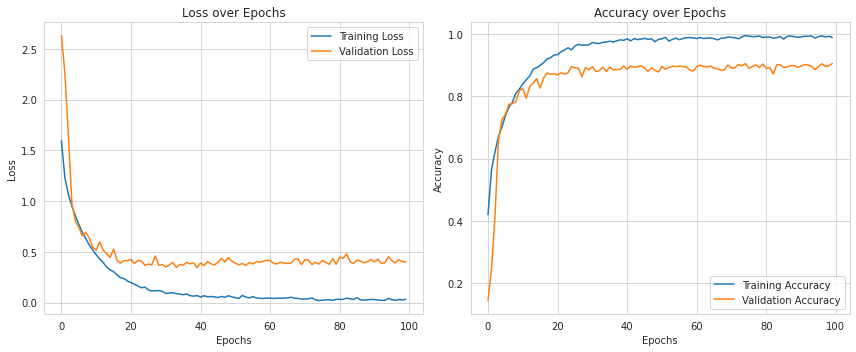

In [39]:
import matplotlib.pyplot as plt

# Plotting the loss
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [37]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Embedding, Bidirectional
from keras.callbacks import ReduceLROnPlateau

# Sample parameters (adjust these based on your specific case)
vocab_size = 10000  # Size of your vocabulary
embedding_dim = 128
max_length = 100    # Max length of input sequences
lstm_units = 128
num_classes = 10    # Change this based on your classification problem
batch_size = 64
epochs = 100

# Create the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model.add(Bidirectional(LSTM(lstm_units, return_sequences=True)))
model.add(Dropout(0.5))  # Dropout layer to reduce overfitting
model.add(Bidirectional(LSTM(lstm_units)))
model.add(Dropout(0.5))  # Another dropout layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))  # Additional dropout layer
model.add(Dense(num_classes, activation='softmax'))  # Change num_classes based on your problem

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Learning rate reduction on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Fit the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[reduce_lr])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


NameError: name 'X_val' is not defined

****CNN-LSTM with Attention with RMSprop****

In [37]:
import tensorflow as tf
from tensorflow.keras import models, layers, Input, callbacks
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, BatchNormalization, Activation, Concatenate, Dropout

# Custom attention layer
class AttentionLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]),
                                 initializer="glorot_uniform",
                                 trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],),
                                 initializer="zeros",
                                 trainable=True)
        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer="glorot_uniform",
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        uit = tf.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        ait = tf.tensordot(uit, self.u, axes=1)
        ait = tf.nn.softmax(ait, axis=1)
        weighted_input = x * tf.expand_dims(ait, -1)
        return tf.reduce_sum(weighted_input, axis=1)

# CNN-LSTM with Attention for Audio Data
def create_parallel_model_with_attention(input_shape):
    # First Branch
    branch1_input = Input(shape=input_shape)
    x1 = Conv1D(64, kernel_size=5, padding='same')(branch1_input)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = MaxPooling1D(pool_size=2)(x1)
    x1 = Dropout(0.3)(x1)  # Dropout for regularization
    
    x1 = Conv1D(128, kernel_size=5, padding='same')(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = MaxPooling1D(pool_size=2)(x1)
    x1 = Dropout(0.3)(x1)
    
    x1 = Conv1D(256, kernel_size=5, padding='same')(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = MaxPooling1D(pool_size=2)(x1)

    # Second Branch
    branch2_input = Input(shape=input_shape)
    y2 = Conv1D(64, kernel_size=5, padding='same')(branch2_input)
    y2 = BatchNormalization()(y2)
    y2 = Activation('relu')(y2)
    y2 = MaxPooling1D(pool_size=2)(y2)
    y2 = Dropout(0.3)(y2)
    
    y2 = Conv1D(128, kernel_size=5, padding='same')(y2)
    y2 = BatchNormalization()(y2)
    y2 = Activation('relu')(y2)
    y2 = MaxPooling1D(pool_size=2)(y2)
    y2 = Dropout(0.3)(y2)
    
    y2 = Conv1D(256, kernel_size=5, padding='same')(y2)
    y2 = BatchNormalization()(y2)
    y2 = Activation('relu')(y2)
    y2 = MaxPooling1D(pool_size=2)(y2)

    # Combine both branches
    combined = Concatenate()([x1, y2])

    # Keep the 3D structure before the LSTM (skip GlobalAveragePooling1D)
    
    # Add LSTM layer
    z = LSTM(128, return_sequences=True, recurrent_dropout=0.2)(combined)

    # Attention Layer
    attention_output = AttentionLayer()(z)

    # Output layer (10-class classification)
    output = Dense(10, activation="softmax")(attention_output)

    # Build model
    model = models.Model(inputs=[branch1_input, branch2_input], outputs=output)
    return model

# Input shape for the model
input_shape = (57, 1)

# Create the model
parallel_cnn_lstm_attention_model = create_parallel_model_with_attention(input_shape)

# Compile the model with RMSprop optimizer
parallel_cnn_lstm_attention_model.compile(optimizer='rmsprop', 
                                          loss='sparse_categorical_crossentropy', 
                                          metrics=['accuracy'])

# Print the model summary
parallel_cnn_lstm_attention_model.summary()

# Callbacks for early stopping and checkpointing
early_stopping_cb = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint_cb = callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)

# Learning rate scheduler
reduce_lr_cb = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Training the model with callbacks
history = parallel_cnn_lstm_attention_model.fit([X_train, X_train], y_train, 
                                                epochs=100, 
                                                batch_size=64, 
                                                validation_data=([X_dev, X_dev], y_dev), 
                            )

# Evaluate the model on the test set
test_loss, test_acc = parallel_cnn_lstm_attention_model.evaluate([X_test, X_test], y_test, batch_size=64)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)


Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 57, 1)]      0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 57, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 57, 64)       384         input_7[0][0]                    
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 57, 64)       384         input_8[0][0]                    
_______________________________________________________________________________________

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers, Input, callbacks
from tensorflow.keras.layers import Dense, LSTM, BatchNormalization, Dropout, Reshape

# Custom attention layer
class AttentionLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]),
                                 initializer="glorot_uniform",
                                 trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],),
                                 initializer="zeros",
                                 trainable=True)
        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer="glorot_uniform",
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        uit = tf.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        ait = tf.tensordot(uit, self.u, axes=1)
        ait = tf.nn.softmax(ait, axis=1)
        weighted_input = x * tf.expand_dims(ait, -1)
        return tf.reduce_sum(weighted_input, axis=1)

# Model architecture replacing Conv layers with Dense layers
def create_model_with_dense_and_lstm(input_shape):
    # First branch input
    branch_input = Input(shape=input_shape)
    
    # Dense block
    x = Dense(1024, activation='relu')(branch_input)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    # Reshape the output for LSTM layers
    reshaped = Reshape((57, 512))(x)  # Assuming input shape [57, 1] is expanded to [57, 512]
    
    # LSTM layers
    lstm_out = LSTM(64, return_sequences=True)(reshaped)
    lstm_out = BatchNormalization()(lstm_out)
    lstm_out = LSTM(64, return_sequences=False)(lstm_out)
    lstm_out = BatchNormalization()(lstm_out)
    
    # Dense layers after LSTM
    dense_out = Dense(256, activation='relu')(lstm_out)
    dense_out = BatchNormalization()(dense_out)
    dense_out = Dropout(0.3)(dense_out)

    dense_out = Dense(128, activation='relu')(dense_out)
    dense_out = BatchNormalization()(dense_out)
    dense_out = Dropout(0.3)(dense_out)

    dense_out = Dense(64, activation='relu')(dense_out)
    dense_out = BatchNormalization()(dense_out)
    dense_out = Dropout(0.3)(dense_out)

    # Output layer (10-class classification)
    output = Dense(10, activation='softmax')(dense_out)

    # Build model
    model = models.Model(inputs=branch_input, outputs=output)
    return model

# Input shape for the model
input_shape = (57, 1)

# Create the model
parallel_model_with_dense_lstm = create_model_with_dense_and_lstm(input_shape)

# Compile the model
parallel_model_with_dense_lstm.compile(optimizer='rmsprop', 
                                       loss='sparse_categorical_crossentropy', 
                                       metrics=['accuracy'])

# Print the model summary
parallel_model_with_dense_lstm.summary()

# Callbacks for early stopping and checkpointing
early_stopping_cb = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint_cb = callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)

# Learning rate scheduler
reduce_lr_cb = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Training the model with callbacks
history = parallel_model_with_dense_lstm.fit(X_train, y_train, 
                                             epochs=100, 
                                             batch_size=64, 
                                             validation_data=(X_dev, y_dev), 
                                )

# Evaluate the model on the test set
test_loss, test_acc = parallel_model_with_dense_lstm.evaluate(X_test, y_test, batch_size=64)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 57, 1)]           0         
_________________________________________________________________
dense (Dense)                (None, 57, 1024)          2048      
_________________________________________________________________
batch_normalization (BatchNo (None, 57, 1024)          4096      
_________________________________________________________________
dropout (Dropout)            (None, 57, 1024)          0         
_________________________________________________________________
dense_1 (Dense)              (None, 57, 512)           524800    
_________________________________________________________________
batch_normalization_1 (Batch (None, 57, 512)           2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 57, 512)          

NameError: name 'X_train' is not defined

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import LearningRateScheduler

# Learning rate schedule function
def lr_schedule(epoch, lr):
    if epoch > 100:
        lr = lr * 0.1
    return lr

# Model Definition
model_4 = Sequential([
    
    # First Dense block with Batch Normalization
    Dense(1024, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    
    # Second Dense block with Batch Normalization
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Reshape layer to feed into LSTM (adding a timesteps dimension)
    Reshape((1, 512)),  # Reshape to (timesteps=1, features=512)

    # LSTM layers
    LSTM(64, return_sequences=True),
    BatchNormalization(),  # Normalization after LSTM
    LSTM(64, return_sequences=False),
    BatchNormalization(),

    # Reduced Dense blocks after LSTM layers with Batch Normalization
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Output layer with softmax for classification
    Dense(10, activation='softmax'),
])

# Print the model summary
print(model_4.summary())

# Custom callback to stop training if accuracy threshold is reached
ACCURACY_THRESHOLD = 0.94
class myCallback(k.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > ACCURACY_THRESHOLD):
            print("\n\nStopping training as we have reached %2.2f%% accuracy!" % (ACCURACY_THRESHOLD*100))   
            self.model.stop_training = True

# Compile the model
callback = myCallback()
lr_scheduler = LearningRateScheduler(lr_schedule)

def trainModel(model, epochs, optimizer):
    batch_size = 128
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model.fit(X_train, y_train, validation_data=(X_dev, y_dev), 
                     epochs=epochs, batch_size=batch_size, callbacks=[callback, lr_scheduler])

# Train the model
model_4_history = trainModel(model=model_4, epochs=100, optimizer='rmsprop')

# Evaluate the model on the test set
test_loss, test_acc = model_4.evaluate(X_test, y_test, batch_size=128)
print("The test Loss is:", test_loss)
print("The Best test Accuracy is:", test_acc * 100)

# Plot training history
def plotHistory(history):
    print("Max. Validation Accuracy:", max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=(12, 6))
    plt.show()

plotHistory(model_4_history)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1024)              59392     
_________________________________________________________________
batch_normalization_6 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 512)           

****Sequential model with dense layers and LSTMs for temporal feature extraction.****


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_274 (Dense)            (None, 1024)              59392     
_________________________________________________________________
batch_normalization_13 (Batc (None, 1024)              4096      
_________________________________________________________________
dropout_226 (Dropout)        (None, 1024)              0         
_________________________________________________________________
dense_275 (Dense)            (None, 512)               524800    
_________________________________________________________________
batch_normalization_14 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_227 (Dropout)        (None, 512)               0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 1, 512)           

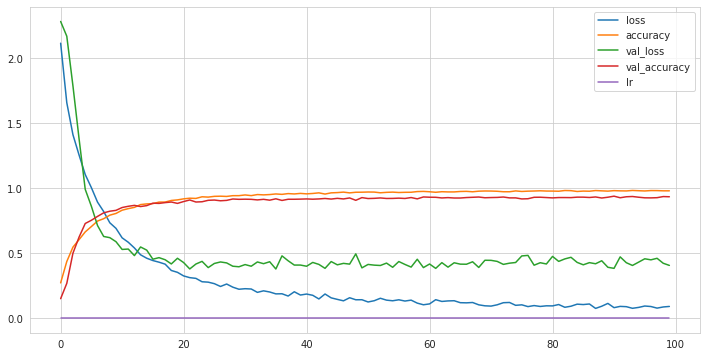

In [47]:
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import LearningRateScheduler

# Learning rate schedule function
def lr_schedule(epoch, lr):
    if epoch > 100:
        lr = lr * 0.1
    return lr

# Model Definition with Bottleneck after LSTM layers
model_4 = Sequential([
    
    # First Dense block with Batch Normalization
    Dense(1024, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    
    # Second Dense block with Batch Normalization
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Reshape layer to feed into LSTM (adding a timesteps dimension)
    Reshape((1, 512)),  # Reshape to (timesteps=1, features=512)

    # LSTM layers to extract temporal features
    LSTM(128, return_sequences=True),
    BatchNormalization(),  # Normalization after first LSTM
    LSTM(64, return_sequences=False),
    BatchNormalization(),

    # Bottleneck: Dense layers after LSTM with reducing neuron sizes
    Dense(64, activation='relu'),  # Bottleneck begins here
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),   # Further compression
    BatchNormalization(),
    Dropout(0.3),

    Dense(16, activation='relu'),   # Narrow bottleneck
    BatchNormalization(),
    Dropout(0.3),

    # Final output layer with softmax for classification
    Dense(10, activation='softmax'),
])

# Print the model summary
print(model_4.summary())

# Custom callback to stop training if accuracy threshold is reached
ACCURACY_THRESHOLD = 0.94
class myCallback(k.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > ACCURACY_THRESHOLD):
            print("\n\nStopping training as we have reached %2.2f%% accuracy!" % (ACCURACY_THRESHOLD*100))   
            self.model.stop_training = True

# Compile the model
callback = myCallback()
lr_scheduler = LearningRateScheduler(lr_schedule)

def trainModel(model, epochs, optimizer):
    batch_size = 128
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model.fit(X_train, y_train, validation_data=(X_dev, y_dev), 
                     epochs=epochs, batch_size=batch_size, callbacks=[callback, lr_scheduler])

# Train the model
model_4_history = trainModel(model=model_4, epochs=100, optimizer='rmsprop')

# Evaluate the model on the test set
test_loss, test_acc = model_4.evaluate(X_test, y_test, batch_size=128)
print("The test Loss is:", test_loss)
print("The Best test Accuracy is:", test_acc * 100)

# Plot training history
def plotHistory(history):
    print("Max. Validation Accuracy:", max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=(12, 6))
    plt.show()

plotHistory(model_4_history)


****Sequential model with bidirectional LSTMs and increased dropout rates****

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_280 (Dense)            (None, 1024)              59392     
_________________________________________________________________
batch_normalization_20 (Batc (None, 1024)              4096      
_________________________________________________________________
dropout_231 (Dropout)        (None, 1024)              0         
_________________________________________________________________
dense_281 (Dense)            (None, 512)               524800    
_________________________________________________________________
batch_normalization_21 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_232 (Dropout)        (None, 512)               0         
_________________________________________________________________
reshape_6 (Reshape)          (None, 1, 512)           

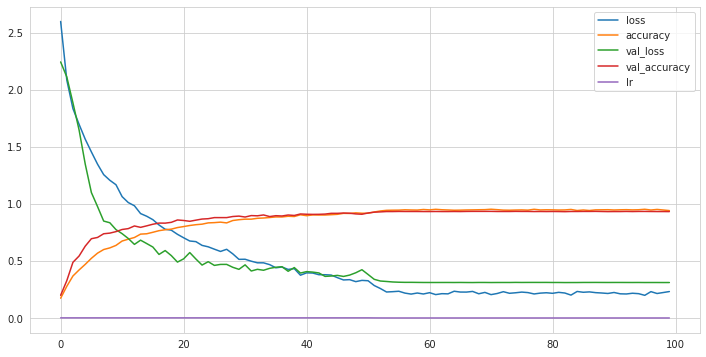

In [48]:
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Reshape, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import LearningRateScheduler

# Learning rate schedule function
def lr_schedule(epoch, lr):
    if epoch > 80:
        return lr * 0.1
    elif epoch > 50:
        return lr * 0.5
    return lr

model_4 = Sequential([
    
    Dense(1024, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),  
    
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),  # Increased dropout
    
    Reshape((1, 512)),  # Reshape to (timesteps=1, features=512)

    Bidirectional(LSTM(128, return_sequences=True)),
    BatchNormalization(),  # Normalization after first LSTM
    Bidirectional(LSTM(64, return_sequences=False)),  # Bidirectional LSTM for forward and backward context
    BatchNormalization(),

    Dense(64, activation='relu'),  # Bottleneck begins here
    BatchNormalization(),
    Dropout(0.4),  # Increased dropout

    Dense(32, activation='relu'),   # Further compression
    BatchNormalization(),
    Dropout(0.4),

    Dense(16, activation='relu'),   # Narrow bottleneck
    BatchNormalization(),
    Dropout(0.4),

    # Final output layer with softmax for classification
    Dense(10, activation='softmax'),
])

# Print the model summary
print(model_4.summary())

# Custom callback to stop training if accuracy threshold is reached
ACCURACY_THRESHOLD = 0.94
class myCallback(k.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > ACCURACY_THRESHOLD):
            print("\n\nStopping training as we have reached %2.2f%% accuracy!" % (ACCURACY_THRESHOLD*100))   
            self.model.stop_training = True

# Compile the model with 'adam' optimizer for better performance
callback = myCallback()
lr_scheduler = LearningRateScheduler(lr_schedule)

def trainModel(model, epochs, optimizer):
    batch_size = 128
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model.fit(X_train, y_train, validation_data=(X_dev, y_dev), 
                     epochs=epochs, batch_size=batch_size, callbacks=[callback, lr_scheduler])

# Train the model
model_4_history = trainModel(model=model_4, epochs=100, optimizer='adam')

# Evaluate the model on the test set
test_loss, test_acc = model_4.evaluate(X_test, y_test, batch_size=128)
print("The test Loss is:", test_loss)
print("The Best test Accuracy is:", test_acc * 100)

# Plot training history
def plotHistory(history):
    print("Max. Validation Accuracy:", max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=(12, 6))
    plt.show()

plotHistory(model_4_history)


****Sequential model with attention mechanism and bidirectional LSTMs.****

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 57)]         0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 1024)         59392       input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 1024)         4096        dense_6[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 1024)         0           batch_normalization_7[0][0]      
_______________________________________________________________________________________

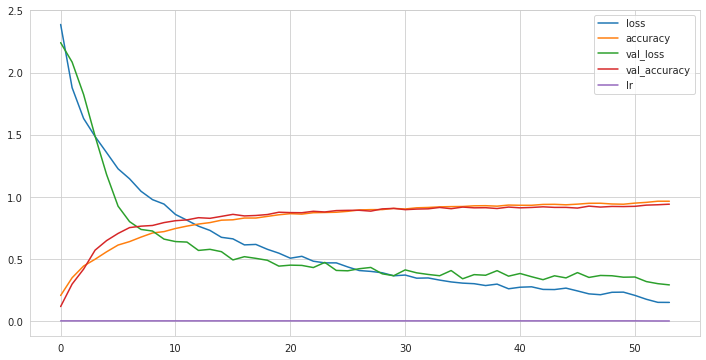

In [34]:
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Reshape, Bidirectional, Attention, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def lr_schedule(epoch, lr):
    if epoch > 80:
        return lr * 0.1
    elif epoch > 50:
        return lr * 0.5
    return lr

def create_model(input_shape):
    inputs = Input(shape=input_shape)
    
    # Dense block
    x = Dense(1024, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    x = Reshape((1, 512))(x)  # Reshape to (timesteps=1, features=512)

    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = BatchNormalization()(x)
    
    query = x
    value = x
    x = Attention()([query, value])

    x = Bidirectional(LSTM(64, return_sequences=False))(x)
    x = BatchNormalization()(x)

    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(16, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

input_shape = (X_train.shape[1],)
model_4 = create_model(input_shape)

print(model_4.summary())

ACCURACY_THRESHOLD = 0.94
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') > ACCURACY_THRESHOLD:
            print("\n\nStopping training as we have reached %2.2f%% accuracy!" % (ACCURACY_THRESHOLD * 100))   
            self.model.stop_training = True

callback = myCallback()
lr_scheduler = LearningRateScheduler(lr_schedule)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

def trainModel(model, epochs, optimizer):
    batch_size = 128
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model.fit(X_train, y_train, validation_data=(X_dev, y_dev), 
                     epochs=epochs, batch_size=batch_size, callbacks=[callback, lr_scheduler])

model_4_history = trainModel(model=model_4, epochs=100, optimizer='adam')

test_loss, test_acc = model_4.evaluate(X_test, y_test, batch_size=128)
print("The test Loss is:", test_loss)
print("The Best test Accuracy is:", test_acc * 100)

def plotHistory(history):
    print("Max. Validation Accuracy:", max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=(12, 6))
    plt.show()

plotHistory(model_4_history)


In [ ]:
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Reshape, Bidirectional, Attention, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Learning rate schedule function
def lr_schedule(epoch, lr):
    if epoch > 80:
        return lr * 0.1
    elif epoch > 50:
        return lr * 0.5
    return lr

# Model definition with Attention layer
def create_model(input_shape):
    inputs = Input(shape=input_shape)
    
    # Dense block
    x = Dense(1024, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    # Reshape to 3D to feed into LSTM
    x = Reshape((1, 512))(x)  # Reshape to (timesteps=1, features=512)

    # LSTM layers with Bidirectional
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = BatchNormalization()(x)
    
    # Using self-attention: passing LSTM output as both query and value
    query = x
    value = x
    x = Attention()([query, value])

    # LSTM continuation after attention
    x = Bidirectional(LSTM(64, return_sequences=False))(x)
    x = BatchNormalization()(x)

    # Bottleneck layers (narrowing network)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(16, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Final output layer for classification
    outputs = Dense(10, activation='softmax')(x)

    # Build the model
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Creating the model
input_shape = (X_train.shape[1],)
model_4 = create_model(input_shape)

# Print model summary
print(model_4.summary())

# Learning rate scheduler
lr_scheduler = LearningRateScheduler(lr_schedule)

# Train model function
def trainModel(model, epochs, optimizer):
    batch_size = 128
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model.fit(X_train, y_train, validation_data=(X_dev, y_dev), 
                     epochs=epochs, batch_size=batch_size, callbacks=[lr_scheduler])

# Train the model
model_4_history = trainModel(model=model_4, epochs=100, optimizer='rmsprop')

# Evaluate the model on the test set
test_loss, test_acc = model_4.evaluate(X_test, y_test, batch_size=128)
print("The test Loss is:", test_loss)
print("The Best test Accuracy is:", test_acc * 100)

# Plot training history


Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 57)]         0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 1024)         59392       input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 1024)         4096        dense_6[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 1024)         0           batch_normalization_7[0][0]      
_______________________________________________________________________________________

Max. Validation Accuracy: 0.9373103976249695
The Best test Accuracy is: 94.30814385414124
The test Loss is: 0.28804466128349304


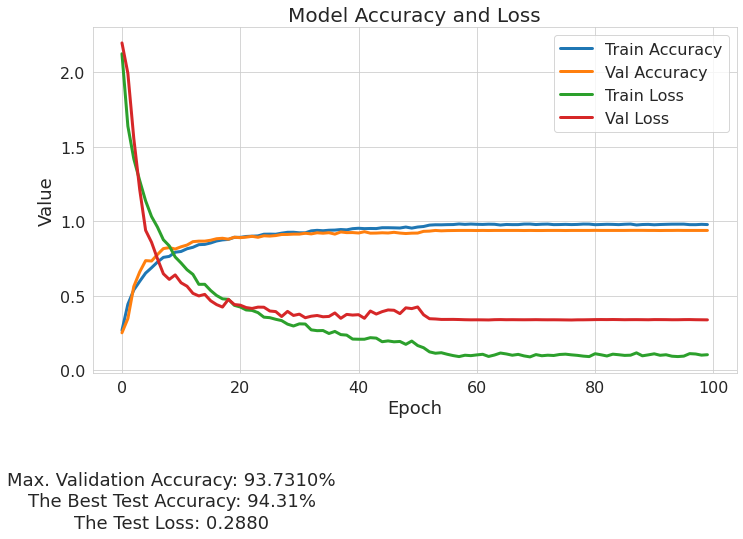

In [26]:
# Plot training history
def plotHistory(history, test_acc, test_loss):
    print("Max. Validation Accuracy:", max(history.history["val_accuracy"]))
    print("The Best test Accuracy is:", test_acc * 100)
    print("The test Loss is:", test_loss)

    # Create the plot with a reduced figure size
    plt.figure(figsize=(10, 6))  # Reduced image size
    
    # Plot accuracy and loss with thicker lines
    plt.plot(history.history["accuracy"], label="Train Accuracy", linewidth=3)  # Increase line thickness
    plt.plot(history.history["val_accuracy"], label="Val Accuracy", linewidth=3)  # Increase line thickness
    plt.plot(history.history["loss"], label="Train Loss", linewidth=3)  # Increase line thickness
    plt.plot(history.history["val_loss"], label="Val Loss", linewidth=3)  # Increase line thickness
    
    # Set labels and title with increased font size
    plt.title('Model Accuracy and Loss', fontsize=20)
    plt.xlabel('Epoch', fontsize=18)
    plt.ylabel('Value', fontsize=18)
    
    # Set ticks font size
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    
    # Set legend with bigger font size
    plt.legend(fontsize=16)
    
    # Print the metrics below the graph with larger font size using figtext
    plt.figtext(0.2,-0.1, f"Max. Validation Accuracy: {max(history.history['val_accuracy'])*100:.4f}%", 
                fontsize=18, ha='center', va='top', wrap=True)
    plt.figtext(0.2, -0.15, f"The Best Test Accuracy: {test_acc * 100:.2f}%", 
                fontsize=18, ha='center', va='top', wrap=True)
    plt.figtext(0.2, -0.2, f"The Test Loss: {test_loss:.4f}", 
                fontsize=18, ha='center', va='top', wrap=True)

    # Show plot
    plt.tight_layout()  # Adjust layout to prevent text from being cut off
    plt.show()

# Assuming 'test_acc' and 'test_loss' are already available
plotHistory(model_4_history, test_acc, test_loss)


In [20]:
model_4.save('mod4.h5')

In [31]:
# import librosa
# import numpy as np

# # Load your model
# model = create_model(input_shape=(57,))  # Assuming 57 features
# model.load_weights('mod4.h5')  # Load trained weights

# # Define the label mappings
# index_label = {
#     0: 'Blues', 1: 'Classical', 2: 'Country', 3: 'Disco', 4: 'Hiphop',
#     5: 'Jazz', 6: 'Metal', 7: 'Pop', 8: 'Reggae', 9: 'Rock'
# }

# # Preprocess audio file
# def preprocess_audio(file_path):
#     # Load audio file using librosa
#     audio, sr = librosa.load(file_path, sr=None, duration=30)  # Ensure 30-second duration
#     # Extract MFCC features (adjust n_mfcc to match the training setup)
#     mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=57)  # Should match what you used in training
#     # Normalize MFCCs (if you did normalization during training)
#     mfccs = np.mean(mfccs.T, axis=0)  # Take the mean of MFCC across time axis to get the right shape (57,)
    
#     # Ensure the shape is (1, 57) before passing into the model
#     mfccs = np.expand_dims(mfccs, axis=0)
#     return mfccs

# # Prediction function
# def predict_genre(file_path):
#     # Preprocess the input audio file
#     input_data = preprocess_audio(file_path)
    
#     # Get model predictions
#     predictions = model.predict(input_data)
    
#     # Extract the predicted index (the index of the highest probability)
#     predicted_index = np.argmax(predictions)
    
#     # Map the index to the corresponding genre
#     predicted_label = index_label[predicted_index]
    
#     return predicted_label

# # Test with an audio file
# file_path = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/metal/metal.00055.wav'  # Path to the audio file
# predicted_genre = predict_genre(file_path)
# print(f'The predicted genre is: {predicted_genre}')


The predicted genre is: Blues


In [17]:
# import librosa
# import numpy as np
# from tensorflow.keras.models import load_model
# import time  # To control the pacing of predictions

# # Load your trained model
# model = load_model('mod4.h5')

# # Genre mapping
# index_label = {
#     0: 'jazz', 1: 'pop', 2: 'blues', 3: 'reggae',
#     4: 'metal', 5: 'disco', 6: 'rock', 7: 'classical',
#     8: 'hiphop', 9: 'country'
# }

# # Function to predict genre
# def predict_genre(chunk, model):
#     chunk_features = extract_features(chunk)  # Extract features for the model input
#     genre_index = np.argmax(model.predict(np.array([chunk_features])), axis=-1)[0]
#     return index_label[genre_index]

# # Function to process and predict genres dynamically in an audio file
# def dynamic_genre_prediction(file_path, model, chunk_duration=5, overlap_duration=2):
#     previous_genre = None
#     sample_rate = 22050  # Standard sample rate
#     audio, sr = librosa.load(file_path, sr=sample_rate)
    
#     # Calculate number of samples per chunk and overlap
#     chunk_samples = chunk_duration * sample_rate
#     overlap_samples = overlap_duration * sample_rate
    
#     # Calculate the total number of chunks (with overlap)
#     num_chunks = int((len(audio) - chunk_samples) / (chunk_samples - overlap_samples)) + 1
    
#     for i in range(num_chunks):
#         start_sample = i * (chunk_samples - overlap_samples)
#         end_sample = start_sample + chunk_samples
        
#         # Ensure we don't exceed the audio length
#         if end_sample > len(audio):
#             break
            
#         chunk = audio[start_sample:end_sample]
        
#         # Predict genre for the current chunk
#         genre = predict_genre(chunk, model)
        
#         # Print the genre if it changes
#         if genre != previous_genre:
#             print(f"Genre changed to: {genre}")
#             previous_genre = genre
            
#         time.sleep(0.1)  # Optional: add a slight delay to control output speed

# def extract_features(chunk):
#     # Extract features that your model expects
#     mfccs = librosa.feature.mfcc(y=chunk, sr=22050, n_mfcc=57)  # Adjust n_mfcc to match your model
#     mfccs = np.mean(mfccs.T, axis=0)
#     return mfccs

# # Example usage
# dynamic_genre_prediction(af, model, chunk_duration=5, overlap_duration=2)


Genre changed to: disco
Genre changed to: jazz
Genre changed to: disco
Genre changed to: jazz


In [21]:
af = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/country/country.00005.wav'


In [25]:
# import librosa
# import numpy as np

# # Function to load and preprocess audio file
# def load_audio(file_path, sr=22050):
#     # Load the audio file
#     audio, _ = librosa.load(file_path, sr=sr, duration=30)  # Load only the first 30 seconds
#     return audio

# # Function to extract features from audio, updated to return 57 MFCCs
# def extract_features(audio, sr=22050, n_mfcc=57):
#     # Extract MFCC features
#     mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
#     mfccs_processed = np.mean(mfccs.T, axis=0)  # Take the mean across time
#     return mfccs_processed

# # Function to segment audio into chunks and make predictions
# def predict_genres(model, audio, chunk_size=2, sr=22050):
#     genres = []
#     # Calculate the number of samples per chunk
#     samples_per_chunk = chunk_size * sr
#     num_chunks = len(audio) // samples_per_chunk
    
#     for i in range(num_chunks):
#         start = i * samples_per_chunk
#         end = start + samples_per_chunk
#         chunk = audio[start:end]

#         # Extract features from the chunk
#         features = extract_features(chunk, sr=sr)

#         # Reshape for the model input (1, 57)
#         features = features.reshape(1, -1)

#         # Predict the genre
#         prediction = model.predict(features)
#         predicted_genre = np.argmax(prediction, axis=1)[0]
#         genres.append(predicted_genre)

#     return genres

# # Load the audio file
# file_path = af  # Change this to your audio file path
# audio = load_audio(file_path)

# # Make predictions using the model
# predicted_genres = predict_genres(model_4, audio)

# # Display predictions
# for i, genre in enumerate(predicted_genres):
#     print(f"Chunk {i + 1}: Predicted Genre: {genre}")  # Print the predicted genre for each chunk


Chunk 1: Predicted Genre: 5
Chunk 2: Predicted Genre: 0
Chunk 3: Predicted Genre: 7
Chunk 4: Predicted Genre: 5
Chunk 5: Predicted Genre: 5
Chunk 6: Predicted Genre: 5
Chunk 7: Predicted Genre: 5
Chunk 8: Predicted Genre: 0
Chunk 9: Predicted Genre: 0
Chunk 10: Predicted Genre: 0
Chunk 11: Predicted Genre: 5
Chunk 12: Predicted Genre: 5
Chunk 13: Predicted Genre: 5
Chunk 14: Predicted Genre: 5
Chunk 15: Predicted Genre: 5


In [22]:
import pandas as pd
import json

# Load dataset
df = pd.read_csv('/kaggle/input/gtzan-dataset-music-genre-classification/Data/features_3_sec.csv')

# Extract unique genres and create a mapping
unique_genres = df['label'].unique()
genre_mapping = {index: genre for index, genre in enumerate(unique_genres)}

# Save the genre mapping to JSON for use during prediction
with open('genre_mapping.json', 'w') as f:
    json.dump(genre_mapping, f)

print("Genre to Index Mapping:", genre_mapping)


Genre to Index Mapping: {0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}


In [23]:
# Load genre mapping from JSON
with open('genre_mapping.json', 'r') as f:
    genre_mapping = json.load(f)

# Reverse the dictionary to map indices back to genre names
index_to_genre = {int(index): genre for index, genre in genre_mapping.items()}


Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       102
           1       0.97      1.00      0.99       101
           2       0.95      0.86      0.90       102
           3       0.96      0.92      0.94       102
           4       0.96      0.93      0.95       102
           5       0.92      0.96      0.94       102
           6       0.95      0.98      0.97       102
           7       0.94      0.98      0.96       102
           8       0.98      0.93      0.95       102
           9       0.86      0.89      0.88       102

    accuracy                           0.94      1019
   macro avg       0.94      0.94      0.94      1019
weighted avg       0.94      0.94      0.94      1019



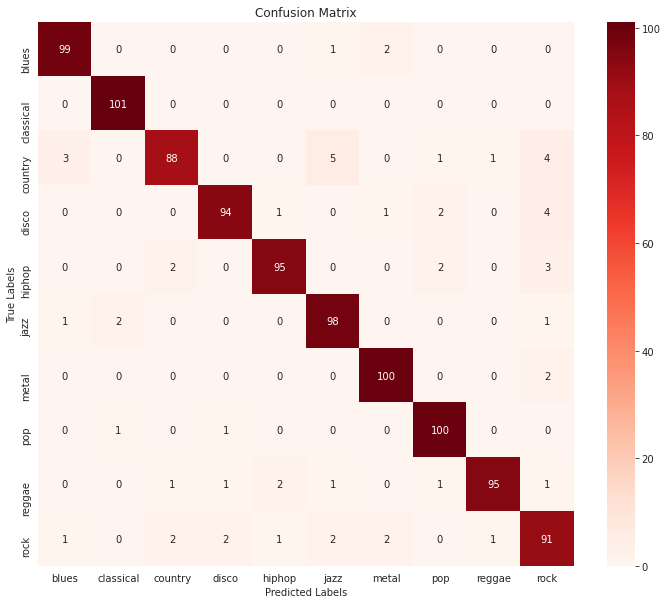

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import json

# Load the genre mapping from JSON (if you haven't already)
with open('genre_mapping.json', 'r') as f:
    genre_mapping = json.load(f)

# Extract genre labels from the mapping
genre_labels = list(genre_mapping.values())

# Evaluate model on test set
y_pred = np.argmax(model_4.predict(X_test), axis=1)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=genre_labels, yticklabels=genre_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [24]:
af = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/blues/blues.00001.wav'


In [28]:
import librosa
import numpy as np
import pandas as pd
import json
from tensorflow.keras.models import load_model

# Function to load and preprocess audio file
def load_audio(file_path, sr=22050):
    audio, _ = librosa.load(file_path, sr=sr, duration=30)  # Load only the first 30 seconds
    return audio

# Function to extract features from audio
def extract_features(audio, sr=22050):
    # Calculate features
    features = {}

    # Chroma features
    chroma_stft = librosa.feature.chroma_stft(y=audio, sr=sr)
    features['chroma_stft_mean'] = np.mean(chroma_stft)
    features['chroma_stft_var'] = np.var(chroma_stft)

    # RMS (Root Mean Square)
    rms = librosa.feature.rms(y=audio)
    features['rms_mean'] = np.mean(rms)
    features['rms_var'] = np.var(rms)

    # Spectral Centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
    features['spectral_centroid_mean'] = np.mean(spectral_centroid)
    features['spectral_centroid_var'] = np.var(spectral_centroid)

    # Spectral Bandwidth
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr)
    features['spectral_bandwidth_mean'] = np.mean(spectral_bandwidth)
    features['spectral_bandwidth_var'] = np.var(spectral_bandwidth)

    # Spectral Rolloff
    rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)
    features['rolloff_mean'] = np.mean(rolloff)
    features['rolloff_var'] = np.var(rolloff)

    # Zero Crossing Rate
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=audio)
    features['zero_crossing_rate_mean'] = np.mean(zero_crossing_rate)
    features['zero_crossing_rate_var'] = np.var(zero_crossing_rate)

    # Harmony
    harmony = librosa.effects.hpss(audio)[1]  # Harmonic part
    features['harmony_mean'] = np.mean(harmony)
    features['harmony_var'] = np.var(harmony)

    # Perceptual features (example implementation; may need adjustment)
    features['perceptr_mean'] = np.mean(np.abs(audio))  # Placeholder, adjust based on your needs
    features['perceptr_var'] = np.var(np.abs(audio))  # Placeholder, adjust based on your needs

    # Tempo
    onset_env = librosa.onset.onset_strength(y=audio, sr=sr)
    features['tempo'] = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)[0]

    # MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20)
    for i in range(20):
        features[f'mfcc{i + 1}_mean'] = np.mean(mfccs[i])
        features[f'mfcc{i + 1}_var'] = np.var(mfccs[i])

    return np.array(list(features.values()))  # Return as 1D array

# Function to segment audio into chunks and make predictions
def predict_genres(model, audio, chunk_size=3, sr=22050, max_previous_chunks=1):
    genres = []
    samples_per_chunk = chunk_size * sr
    num_chunks = len(audio) // samples_per_chunk

    previous_features = []  # Buffer to store features from previous chunks

    for i in range(num_chunks):
        start = i * samples_per_chunk
        end = start + samples_per_chunk
        chunk = audio[start:end]

        # Extract features from the current chunk
        features = extract_features(chunk)

        # Append the current features to the list of previous features
        previous_features.append(features)

        # Limit the number of previous features to the specified max
        if len(previous_features) > max_previous_chunks:
            previous_features.pop(0)  # Keep only the most recent features

        # If there are previous features, average them; else use current features only
        if len(previous_features) > 1:
            averaged_features = np.mean(previous_features[:-1], axis=0)  # Average previous features
            combined_features = np.concatenate((averaged_features, features))
        else:
            combined_features = features  # Only use current features if no previous features

        # Ensure combined_features has the shape (1, 57)
        if combined_features.shape[0] != 57:
            combined_features = combined_features[:57]  # Slice if needed to match expected shape

        # Reshape for model input
        combined_features = combined_features.reshape(1, -1)

        # Predict the genre index
        prediction = model.predict(combined_features)
        predicted_genre_idx = np.argmax(prediction, axis=1)[0]

        # Map the index back to the genre name
        predicted_genre_name = index_to_genre.get(predicted_genre_idx, "Unknown")
        
        # Calculate start and end time for the current chunk
        start_time = start / sr
        end_time = end / sr
        
        # Print the result with time intervals
        print(f"From {start_time:.1f} to {end_time:.1f} seconds: Predicted Genre: {predicted_genre_name}")

        genres.append(predicted_genre_name)

    return genres



# Load your pre-trained model
model = load_model('mod4.h5')

# Load the genre mapping from JSON
with open('genre_mapping.json', 'r') as f:
    genre_mapping = json.load(f)

# Reverse the dictionary for index-to-genre mapping
index_to_genre = {int(index): genre for index, genre in genre_mapping.items()}

# Load and process audio file
file_path = af  # Specify your audio file path here
audio = load_audio(file_path)

# Make predictions on audio chunks
predicted_genres = predict_genres(model, audio)



From 0.0 to 3.0 seconds: Predicted Genre: reggae
From 3.0 to 6.0 seconds: Predicted Genre: hiphop
From 6.0 to 9.0 seconds: Predicted Genre: classical
From 9.0 to 12.0 seconds: Predicted Genre: hiphop
From 12.0 to 15.0 seconds: Predicted Genre: hiphop
From 15.0 to 18.0 seconds: Predicted Genre: hiphop
From 18.0 to 21.0 seconds: Predicted Genre: hiphop
From 21.0 to 24.0 seconds: Predicted Genre: hiphop
From 24.0 to 27.0 seconds: Predicted Genre: hiphop
From 27.0 to 30.0 seconds: Predicted Genre: hiphop


In [39]:
testing_1= "/kaggle/input/test-input-1/test-input-1.wav"

In [48]:
import librosa
import numpy as np
import pandas as pd
import json
from tensorflow.keras.models import load_model

# Function to load and preprocess audio file
def load_audio(file_path, sr=22050):
    audio, _ = librosa.load(file_path, sr=sr, duration=30)  # Load only the first 30 seconds
    return audio

# Function to extract features from audio
def extract_features(audio, sr=22050):
    # Calculate features
    features = {}

    # Chroma features
    chroma_stft = librosa.feature.chroma_stft(y=audio, sr=sr)
    features['chroma_stft_mean'] = np.mean(chroma_stft)
    features['chroma_stft_var'] = np.var(chroma_stft)

    # RMS (Root Mean Square)
    rms = librosa.feature.rms(y=audio)
    features['rms_mean'] = np.mean(rms)
    features['rms_var'] = np.var(rms)

    # Spectral Centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
    features['spectral_centroid_mean'] = np.mean(spectral_centroid)
    features['spectral_centroid_var'] = np.var(spectral_centroid)

    # Spectral Bandwidth
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr)
    features['spectral_bandwidth_mean'] = np.mean(spectral_bandwidth)
    features['spectral_bandwidth_var'] = np.var(spectral_bandwidth)

    # Spectral Rolloff
    rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)
    features['rolloff_mean'] = np.mean(rolloff)
    features['rolloff_var'] = np.var(rolloff)

    # Zero Crossing Rate
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=audio)
    features['zero_crossing_rate_mean'] = np.mean(zero_crossing_rate)
    features['zero_crossing_rate_var'] = np.var(zero_crossing_rate)

    # Harmony
    harmony = librosa.effects.hpss(audio)[1]  # Harmonic part
    features['harmony_mean'] = np.mean(harmony)
    features['harmony_var'] = np.var(harmony)

    # Perceptual features (example implementation; may need adjustment)
    features['perceptr_mean'] = np.mean(np.abs(audio))  # Placeholder, adjust based on your needs
    features['perceptr_var'] = np.var(np.abs(audio))  # Placeholder, adjust based on your needs

    # Tempo
    onset_env = librosa.onset.onset_strength(y=audio, sr=sr)
    features['tempo'] = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)[0]

    # MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20)
    for i in range(20):
        features[f'mfcc{i + 1}_mean'] = np.mean(mfccs[i])
        features[f'mfcc{i + 1}_var'] = np.var(mfccs[i])

    return np.array(list(features.values()))  # Return as 1D array

# Function to segment audio into chunks and make predictions
def predict_genres(model, audio, chunk_size=3, sr=22050, max_previous_chunks=1):
    genres = []
    samples_per_chunk = chunk_size * sr
    num_chunks = len(audio) // samples_per_chunk

    previous_features = []  # Buffer to store features from previous chunks

    for i in range(num_chunks):
        start = i * samples_per_chunk
        end = start + samples_per_chunk
        chunk = audio[start:end]

        # Extract features from the current chunk
        features = extract_features(chunk)

        # Append the current features to the list of previous features
        previous_features.append(features)

        # Limit the number of previous features to the specified max
        if len(previous_features) > max_previous_chunks:
            previous_features.pop(0)  # Keep only the most recent features

        # If there are previous features, average them; else use current features only
        if len(previous_features) > 1:
            averaged_features = np.mean(previous_features[:-1], axis=0)  # Average previous features
            combined_features = np.concatenate((averaged_features, features))
        else:
            combined_features = features  # Only use current features if no previous features

        # Ensure combined_features has the shape (1, 57)
        if combined_features.shape[0] != 57:
            combined_features = combined_features[:57]  # Slice if needed to match expected shape

        # Reshape for model input
        combined_features = combined_features.reshape(1, -1)

        # Predict the genre index
        prediction = model.predict(combined_features)
        predicted_genre_idx = np.argmax(prediction, axis=1)[0]

        # Map the index back to the genre name
        predicted_genre_name = index_to_genre.get(predicted_genre_idx, "Unknown")
        
        # Calculate start and end time for the current chunk
        start_time = start / sr
        end_time = end / sr
        
        # Print the result with time intervals
        print(f"From {start_time:.1f} to {end_time:.1f} seconds: Predicted Genre: {predicted_genre_name}")

        genres.append(predicted_genre_name)

    return genres



# Load your pre-trained model
model = load_model('mod4.h5')

# Load the genre mapping from JSON
with open('genre_mapping.json', 'r') as f:
    genre_mapping = json.load(f)

# Reverse the dictionary for index-to-genre mapping
index_to_genre = {int(index): genre for index, genre in genre_mapping.items()}

# Load and process audio file
file_path = testing_1  # Specify your audio file path here
audio = load_audio(file_path)

# Make predictions on audio chunks
predicted_genres = predict_genres(model, audio)



From 0.0 to 3.0 seconds: Predicted Genre: pop
From 3.0 to 6.0 seconds: Predicted Genre: hiphop
From 6.0 to 9.0 seconds: Predicted Genre: hiphop
From 9.0 to 12.0 seconds: Predicted Genre: classical
From 12.0 to 15.0 seconds: Predicted Genre: hiphop
From 15.0 to 18.0 seconds: Predicted Genre: hiphop
From 18.0 to 21.0 seconds: Predicted Genre: hiphop
From 21.0 to 24.0 seconds: Predicted Genre: hiphop
From 24.0 to 27.0 seconds: Predicted Genre: hiphop


In [31]:
testing_2= "/kaggle/input/test-input-2/test-input-2.wav"

In [32]:
import librosa
import numpy as np
import pandas as pd
import json
from tensorflow.keras.models import load_model

# Function to load and preprocess audio file
def load_audio(file_path, sr=22050):
    audio, _ = librosa.load(file_path, sr=sr, duration=30)  # Load only the first 30 seconds
    return audio

# Function to extract features from audio
def extract_features(audio, sr=22050):
    # Calculate features
    features = {}

    # Chroma features
    chroma_stft = librosa.feature.chroma_stft(y=audio, sr=sr)
    features['chroma_stft_mean'] = np.mean(chroma_stft)
    features['chroma_stft_var'] = np.var(chroma_stft)

    # RMS (Root Mean Square)
    rms = librosa.feature.rms(y=audio)
    features['rms_mean'] = np.mean(rms)
    features['rms_var'] = np.var(rms)

    # Spectral Centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
    features['spectral_centroid_mean'] = np.mean(spectral_centroid)
    features['spectral_centroid_var'] = np.var(spectral_centroid)

    # Spectral Bandwidth
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr)
    features['spectral_bandwidth_mean'] = np.mean(spectral_bandwidth)
    features['spectral_bandwidth_var'] = np.var(spectral_bandwidth)

    # Spectral Rolloff
    rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)
    features['rolloff_mean'] = np.mean(rolloff)
    features['rolloff_var'] = np.var(rolloff)

    # Zero Crossing Rate
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=audio)
    features['zero_crossing_rate_mean'] = np.mean(zero_crossing_rate)
    features['zero_crossing_rate_var'] = np.var(zero_crossing_rate)

    # Harmony
    harmony = librosa.effects.hpss(audio)[1]  # Harmonic part
    features['harmony_mean'] = np.mean(harmony)
    features['harmony_var'] = np.var(harmony)

    # Perceptual features (example implementation; may need adjustment)
    features['perceptr_mean'] = np.mean(np.abs(audio))  # Placeholder, adjust based on your needs
    features['perceptr_var'] = np.var(np.abs(audio))  # Placeholder, adjust based on your needs

    # Tempo
    onset_env = librosa.onset.onset_strength(y=audio, sr=sr)
    features['tempo'] = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)[0]

    # MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20)
    for i in range(20):
        features[f'mfcc{i + 1}_mean'] = np.mean(mfccs[i])
        features[f'mfcc{i + 1}_var'] = np.var(mfccs[i])

    return np.array(list(features.values()))  # Return as 1D array

# Function to segment audio into chunks and make predictions
def predict_genres(model, audio, chunk_size=3, sr=22050, max_previous_chunks=1):
    genres = []
    samples_per_chunk = chunk_size * sr
    num_chunks = len(audio) // samples_per_chunk

    previous_features = []  # Buffer to store features from previous chunks

    for i in range(num_chunks):
        start = i * samples_per_chunk
        end = start + samples_per_chunk
        chunk = audio[start:end]

        # Extract features from the current chunk
        features = extract_features(chunk)

        # Append the current features to the list of previous features
        previous_features.append(features)

        # Limit the number of previous features to the specified max
        if len(previous_features) > max_previous_chunks:
            previous_features.pop(0)  # Keep only the most recent features

        # If there are previous features, average them; else use current features only
        if len(previous_features) > 1:
            averaged_features = np.mean(previous_features[:-1], axis=0)  # Average previous features
            combined_features = np.concatenate((averaged_features, features))
        else:
            combined_features = features  # Only use current features if no previous features

        # Ensure combined_features has the shape (1, 57)
        if combined_features.shape[0] != 57:
            combined_features = combined_features[:57]  # Slice if needed to match expected shape

        # Reshape for model input
        combined_features = combined_features.reshape(1, -1)

        # Predict the genre index
        prediction = model.predict(combined_features)
        predicted_genre_idx = np.argmax(prediction, axis=1)[0]

        # Map the index back to the genre name
        predicted_genre_name = index_to_genre.get(predicted_genre_idx, "Unknown")
        
        # Calculate start and end time for the current chunk
        start_time = start / sr
        end_time = end / sr
        
        # Print the result with time intervals
        print(f"From {start_time:.1f} to {end_time:.1f} seconds: Predicted Genre: {predicted_genre_name}")

        genres.append(predicted_genre_name)

    return genres



# Load your pre-trained model
model = load_model('mod4.h5')

# Load the genre mapping from JSON
with open('genre_mapping.json', 'r') as f:
    genre_mapping = json.load(f)

# Reverse the dictionary for index-to-genre mapping
index_to_genre = {int(index): genre for index, genre in genre_mapping.items()}

# Load and process audio file
file_path = testing_2  # Specify your audio file path here
audio = load_audio(file_path)

# Make predictions on audio chunks
predicted_genres = predict_genres(model, audio)



From 0.0 to 3.0 seconds: Predicted Genre: hiphop
From 3.0 to 6.0 seconds: Predicted Genre: hiphop
From 6.0 to 9.0 seconds: Predicted Genre: hiphop
From 9.0 to 12.0 seconds: Predicted Genre: hiphop
From 12.0 to 15.0 seconds: Predicted Genre: hiphop
From 15.0 to 18.0 seconds: Predicted Genre: hiphop
From 18.0 to 21.0 seconds: Predicted Genre: hiphop
From 21.0 to 24.0 seconds: Predicted Genre: hiphop
From 24.0 to 27.0 seconds: Predicted Genre: hiphop


In [27]:
import librosa
import numpy as np
import json
from tensorflow.keras.models import load_model

# Function to normalize audio
def normalize_audio(audio):
    """Normalize the audio waveform to the range [-1, 1]."""
    return audio / np.max(np.abs(audio))

# Function to load and preprocess audio file
def load_audio(file_path, sr=22050):
    """Load an audio file and return the audio waveform."""
    audio, _ = librosa.load(file_path, sr=sr, duration=30)  # Load only the first 30 seconds
    return normalize_audio(audio)

# Function to extract features from audio
def extract_features(audio, sr=22050):
    """
    Extract various audio features from a given audio signal.
    Returns a feature vector of size 57.
    """
    features = []

    # Chroma features
    chroma_stft = librosa.feature.chroma_stft(y=audio, sr=sr)
    features.append(np.mean(chroma_stft))
    features.append(np.var(chroma_stft))

    # RMS
    rms = librosa.feature.rms(y=audio)
    features.append(np.mean(rms))
    features.append(np.var(rms))

    # Spectral Centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
    features.append(np.mean(spectral_centroid))
    features.append(np.var(spectral_centroid))

    # Spectral Bandwidth
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr)
    features.append(np.mean(spectral_bandwidth))
    features.append(np.var(spectral_bandwidth))

    # Spectral Rolloff
    rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)
    features.append(np.mean(rolloff))
    features.append(np.var(rolloff))

    # Zero Crossing Rate
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=audio)
    features.append(np.mean(zero_crossing_rate))
    features.append(np.var(zero_crossing_rate))

    # Harmony
    harmony = librosa.effects.hpss(audio)[1]
    features.append(np.mean(harmony))
    features.append(np.var(harmony))

    # Tempo
    onset_env = librosa.onset.onset_strength(y=audio, sr=sr)
    features.append(librosa.beat.tempo(onset_envelope=onset_env, sr=sr)[0])

    # MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20)
    for i in range(20):
        features.append(np.mean(mfccs[i]))
        features.append(np.var(mfccs[i]))

    # Ensure feature vector is 57 elements
    assert len(features) == 57, f"Feature vector length is {len(features)}, expected 57"
    return np.array(features)

# Function to segment audio into chunks and make predictions
def predict_genres(model, audio, chunk_size=3, sr=22050, max_previous_chunks=1):
    """
    Predict genres for audio by dividing it into chunks and using a model.
    """
    genres = []
    samples_per_chunk = chunk_size * sr
    num_chunks = len(audio) // samples_per_chunk

    # Initialize the buffer to store features from previous chunks
    previous_features = []

    for i in range(num_chunks):
        start = i * samples_per_chunk
        end = start + samples_per_chunk
        chunk = audio[start:end]

        # Extract features from the current chunk
        features = extract_features(chunk)

        # Append the current features to the list of previous features
        previous_features.append(features)

        # Limit the number of previous features to the specified max
        if len(previous_features) > max_previous_chunks:
            previous_features.pop(0)  # Keep only the most recent features

        # If there are previous features, average them; else use current features only
        if len(previous_features) > 1:
            averaged_features = np.mean(previous_features[:-1], axis=0)  # Average previous features
            combined_features = np.concatenate((averaged_features, features))[:57]  # Slice to ensure 57 elements
        else:
            combined_features = features[:57]  # Only use current features if no previous features

        # Reshape for model input
        combined_features = combined_features.reshape(1, -1)

        # Predict the genre index
        prediction = model.predict(combined_features)
        predicted_genre_idx = np.argmax(prediction, axis=1)[0]

        # Map the index back to the genre name
        predicted_genre_name = index_to_genre.get(predicted_genre_idx, "Unknown")

        # Calculate start and end time for the current chunk
        start_time = start / sr
        end_time = end / sr

        # Print the result with time intervals
        print(f"From {start_time:.1f} to {end_time:.1f} seconds: Predicted Genre: {predicted_genre_name}")

        genres.append(predicted_genre_name)

    return genres

# Load your pre-trained model
model = load_model('mod4.h5')

# Load the genre mapping from JSON
with open('genre_mapping.json', 'r') as f:
    genre_mapping = json.load(f)

# Reverse the dictionary for index-to-genre mapping
index_to_genre = {int(index): genre for index, genre in genre_mapping.items()}

# Load and process audio file
testing_2 = "/kaggle/input/test-input-2/test-input-2.wav"  # Replace with your actual file path
audio = load_audio(testing_2)

# Make predictions on audio chunks
predicted_genres = predict_genres(model, audio)


AssertionError: Feature vector length is 55, expected 57

In [45]:
import librosa
import numpy as np
import json
from tensorflow.keras.models import load_model

# Function to normalize audio
def normalize_audio(audio):
    """Normalize the audio waveform to the range [-1, 1]."""
    return audio / np.max(np.abs(audio))

# Function to load and preprocess audio file
def load_audio(file_path, sr=22050):
    """Load an audio file and return the audio waveform."""
    audio, _ = librosa.load(file_path, sr=sr, duration=30)  # Load only the first 30 seconds
    audio = normalize_audio(audio)
    return audio

# Function to extract features from audio
def extract_features(audio, sr=22050):
    """
    Extract various audio features from a given audio signal.
    Returns a feature vector of size 57.
    """
    features = []

    # Chroma features
    chroma_stft = librosa.feature.chroma_stft(y=audio, sr=sr)
    features.append(np.mean(chroma_stft))
    features.append(np.var(chroma_stft))

    # RMS
    rms = librosa.feature.rms(y=audio)
    features.append(np.mean(rms))
    features.append(np.var(rms))

    # Spectral Centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
    features.append(np.mean(spectral_centroid))
    features.append(np.var(spectral_centroid))

    # Spectral Bandwidth
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr)
    features.append(np.mean(spectral_bandwidth))
    features.append(np.var(spectral_bandwidth))

    # Spectral Rolloff
    rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)
    features.append(np.mean(rolloff))
    features.append(np.var(rolloff))

    # Zero Crossing Rate
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=audio)
    features.append(np.mean(zero_crossing_rate))
    features.append(np.var(zero_crossing_rate))

    # Harmony
    try:
        harmony = librosa.effects.hpss(audio)[1]
        features.append(np.mean(harmony))
        features.append(np.var(harmony))
    except:
        features.append(0)  # Default mean
        features.append(0)  # Default variance

    # Tempo
    onset_env = librosa.onset.onset_strength(y=audio, sr=sr)
    features.append(librosa.beat.tempo(onset_envelope=onset_env, sr=sr)[0])

    # MFCCs (21 coefficients)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=21)
    for i in range(21):
        features.append(np.mean(mfccs[i]))
        features.append(np.var(mfccs[i]))

    # Ensure feature vector is 57 elements
    assert len(features) == 57, f"Feature vector length is {len(features)}, expected 57"
    return np.array(features)


# Function to segment audio into chunks and make predictions
def predict_genres(model, audio, chunk_size=3, sr=22050, max_previous_chunks=1):
    """
    Predict genres for audio by dividing it into chunks and using a model.
    """
    genres = []
    samples_per_chunk = chunk_size * sr
    num_chunks = len(audio) // samples_per_chunk

    # Initialize the buffer to store features from previous chunks
    previous_features = []

    for i in range(num_chunks):
        start = i * samples_per_chunk
        end = start + samples_per_chunk
        chunk = audio[start:end]

        # Extract features from the current chunk
        features = extract_features(chunk)

        # Append the current features to the list of previous features
        previous_features.append(features)

        # Limit the number of previous features to the specified max
        if len(previous_features) > max_previous_chunks:
            previous_features.pop(0)  # Keep only the most recent features

        # If there are previous features, average them; else use current features only
        if len(previous_features) > 1:
            averaged_features = np.mean(previous_features[:-1], axis=0)  # Average previous features
            combined_features = np.concatenate((averaged_features, features))[:57]  # Slice to ensure 57 elements
        else:
            combined_features = features[:57]  # Only use current features if no previous features


        # Reshape for model input
        combined_features = combined_features.reshape(1, -1)

        # Predict the genre index
        prediction = model.predict(combined_features)
        predicted_genre_idx = np.argmax(prediction, axis=1)[0]

        # Map the index back to the genre name
        predicted_genre_name = index_to_genre.get(predicted_genre_idx, "Unknown")

        # Calculate start and end time for the current chunk
        start_time = start / sr
        end_time = end / sr

        # Print the result with time intervals
        print(f"From {start_time:.1f} to {end_time:.1f} seconds: Predicted Genre: {predicted_genre_name}")

        genres.append(predicted_genre_name)

    return genres

# Load your pre-trained model
model = load_model('mod4.h5')

# Load the genre mapping from JSON
with open('genre_mapping.json', 'r') as f:
    genre_mapping = json.load(f)

# Reverse the dictionary for index-to-genre mapping
index_to_genre = {int(index): genre for index, genre in genre_mapping.items()}

# Load and process audio file
testing_2 = "/kaggle/input/test-input-1/test-input-1.wav"  # Replace with your actual file path
audio = load_audio(testing_2)

# Make predictions on audio chunks
predicted_genres = predict_genres(model, audio)


From 0.0 to 3.0 seconds: Predicted Genre: pop
From 3.0 to 6.0 seconds: Predicted Genre: hiphop
From 6.0 to 9.0 seconds: Predicted Genre: hiphop
From 9.0 to 12.0 seconds: Predicted Genre: classical
From 12.0 to 15.0 seconds: Predicted Genre: hiphop
From 15.0 to 18.0 seconds: Predicted Genre: hiphop
From 18.0 to 21.0 seconds: Predicted Genre: hiphop
From 21.0 to 24.0 seconds: Predicted Genre: hiphop
From 24.0 to 27.0 seconds: Predicted Genre: hiphop


In [47]:
import librosa
import numpy as np
import json
from tensorflow.keras.models import load_model

# Function to normalize audio
def normalize_audio(audio):
    """Normalize the audio waveform to the range [-1, 1]."""
    return audio / np.max(np.abs(audio))

# Function to load and preprocess audio file
def load_audio(file_path, sr=22050):
    """Load an audio file and return the audio waveform."""
    audio, _ = librosa.load(file_path, sr=sr, duration=30)  # Load only the first 30 seconds
    audio = normalize_audio(audio)
    return audio

# Function to extract features from audio
def extract_features(audio, sr=22050):
    """
    Extract various audio features from a given audio signal.
    Returns a feature vector of size 57.
    """
    features = []

    # Chroma features
    chroma_stft = librosa.feature.chroma_stft(y=audio, sr=sr)
    features.append(np.mean(chroma_stft))
    features.append(np.var(chroma_stft))

    # RMS
    rms = librosa.feature.rms(y=audio)
    features.append(np.mean(rms))
    features.append(np.var(rms))

    # Spectral Centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
    features.append(np.mean(spectral_centroid))
    features.append(np.var(spectral_centroid))

    # Spectral Bandwidth
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr)
    features.append(np.mean(spectral_bandwidth))
    features.append(np.var(spectral_bandwidth))

    # Spectral Rolloff
    rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)
    features.append(np.mean(rolloff))
    features.append(np.var(rolloff))

    # Zero Crossing Rate
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=audio)
    features.append(np.mean(zero_crossing_rate))
    features.append(np.var(zero_crossing_rate))

    # Harmony
    try:
        harmony = librosa.effects.hpss(audio)[1]
        features.append(np.mean(harmony))
        features.append(np.var(harmony))
    except:
        features.append(0)  # Default mean
        features.append(0)  # Default variance

    # Tempo
    onset_env = librosa.onset.onset_strength(y=audio, sr=sr)
    features.append(librosa.beat.tempo(onset_envelope=onset_env, sr=sr)[0])

    # MFCCs (21 coefficients)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=21)
    for i in range(21):
        features.append(np.mean(mfccs[i]))
        features.append(np.var(mfccs[i]))

    # Ensure feature vector is 57 elements
    assert len(features) == 57, f"Feature vector length is {len(features)}, expected 57"
    return np.array(features)


# Function to segment audio into chunks and make predictions
def predict_genres(model, audio, chunk_size=3, sr=22050, max_previous_chunks=1):
    """
    Predict genres for audio by dividing it into chunks and using a model.
    """
    genres = []
    samples_per_chunk = chunk_size * sr
    num_chunks = len(audio) // samples_per_chunk

    # Initialize the buffer to store features from previous chunks
    previous_features = []

    for i in range(num_chunks):
        start = i * samples_per_chunk
        end = start + samples_per_chunk
        chunk = audio[start:end]

        # Extract features from the current chunk
        features = extract_features(chunk)

        # Append the current features to the list of previous features
        previous_features.append(features)

        # Limit the number of previous features to the specified max
        if len(previous_features) > max_previous_chunks:
            previous_features.pop(0)  # Keep only the most recent features

        # If there are previous features, average them; else use current features only
        if len(previous_features) > 1:
            averaged_features = np.mean(previous_features[:-1], axis=0)  # Average previous features
            combined_features = np.concatenate((averaged_features, features))[:57]  # Slice to ensure 57 elements
        else:
            combined_features = features[:57]  # Only use current features if no previous features


        # Reshape for model input
        combined_features = combined_features.reshape(1, -1)

        # Predict the genre index
        prediction = model.predict(combined_features)
        predicted_genre_idx = np.argmax(prediction, axis=1)[0]

        # Map the index back to the genre name
        predicted_genre_name = index_to_genre.get(predicted_genre_idx, "Unknown")

        # Calculate start and end time for the current chunk
        start_time = start / sr
        end_time = end / sr

        # Print the result with time intervals
        print(f"From {start_time:.1f} to {end_time:.1f} seconds: Predicted Genre: {predicted_genre_name}")

        genres.append(predicted_genre_name)

    return genres

# Load your pre-trained model
model = load_model('mod4.h5')

# Load the genre mapping from JSON
with open('genre_mapping.json', 'r') as f:
    genre_mapping = json.load(f)

# Reverse the dictionary for index-to-genre mapping
index_to_genre = {int(index): genre for index, genre in genre_mapping.items()}

# Load and process audio file
testing_2 = "/kaggle/input/test-input-3/test-input-3.wav"  # Replace with your actual file path
audio = load_audio(testing_2)

# Make predictions on audio chunks
predicted_genres = predict_genres(model, audio)


From 0.0 to 3.0 seconds: Predicted Genre: hiphop
From 3.0 to 6.0 seconds: Predicted Genre: hiphop
From 6.0 to 9.0 seconds: Predicted Genre: hiphop
From 9.0 to 12.0 seconds: Predicted Genre: hiphop
From 12.0 to 15.0 seconds: Predicted Genre: hiphop
From 15.0 to 18.0 seconds: Predicted Genre: reggae
From 18.0 to 21.0 seconds: Predicted Genre: hiphop
From 21.0 to 24.0 seconds: Predicted Genre: reggae
From 24.0 to 27.0 seconds: Predicted Genre: reggae


In [28]:
import librosa
import numpy as np
import json
from tensorflow.keras.models import load_model

# Function to normalize audio
def normalize_audio(audio):
    """Normalize the audio waveform to the range [-1, 1]."""
    return audio / np.max(np.abs(audio))

# Function to load and preprocess audio file
def load_audio(file_path, sr=22050):
    """Load an audio file and return the audio waveform."""
    audio, _ = librosa.load(file_path, sr=sr, duration=30)  # Load only the first 30 seconds
    audio = normalize_audio(audio)
    return audio

# Function to extract features from audio
def extract_features(audio, sr=22050):
    """
    Extract various audio features from a given audio signal.
    Returns a feature vector of size 57.
    """
    features = []

    # Chroma features
    chroma_stft = librosa.feature.chroma_stft(y=audio, sr=sr)
    features.append(np.mean(chroma_stft))
    features.append(np.var(chroma_stft))

    # RMS
    rms = librosa.feature.rms(y=audio)
    features.append(np.mean(rms))
    features.append(np.var(rms))

    # Spectral Centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
    features.append(np.mean(spectral_centroid))
    features.append(np.var(spectral_centroid))

    # Spectral Bandwidth
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr)
    features.append(np.mean(spectral_bandwidth))
    features.append(np.var(spectral_bandwidth))

    # Spectral Rolloff
    rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)
    features.append(np.mean(rolloff))
    features.append(np.var(rolloff))

    # Zero Crossing Rate
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=audio)
    features.append(np.mean(zero_crossing_rate))
    features.append(np.var(zero_crossing_rate))

    # Harmony
    try:
        harmony = librosa.effects.hpss(audio)[1]
        features.append(np.mean(harmony))
        features.append(np.var(harmony))
    except:
        features.append(0)  # Default mean
        features.append(0)  # Default variance

    # Tempo
    onset_env = librosa.onset.onset_strength(y=audio, sr=sr)
    features.append(librosa.beat.tempo(onset_envelope=onset_env, sr=sr)[0])

    # MFCCs (21 coefficients)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=21)
    for i in range(21):
        features.append(np.mean(mfccs[i]))
        features.append(np.var(mfccs[i]))

    # Ensure feature vector is 57 elements
    assert len(features) == 57, f"Feature vector length is {len(features)}, expected 57"
    return np.array(features)


# Function to segment audio into chunks and make predictions
def predict_genres(model, audio, chunk_size=3, sr=22050, max_previous_chunks=1):
    """
    Predict genres for audio by dividing it into chunks and using a model.
    """
    genres = []
    samples_per_chunk = chunk_size * sr
    num_chunks = len(audio) // samples_per_chunk

    # Initialize the buffer to store features from previous chunks
    previous_features = []

    for i in range(num_chunks):
        start = i * samples_per_chunk
        end = start + samples_per_chunk
        chunk = audio[start:end]

        # Extract features from the current chunk
        features = extract_features(chunk)

        # Append the current features to the list of previous features
        previous_features.append(features)

        # Limit the number of previous features to the specified max
        if len(previous_features) > max_previous_chunks:
            previous_features.pop(0)  # Keep only the most recent features

        # If there are previous features, average them; else use current features only
        if len(previous_features) > 1:
            averaged_features = np.mean(previous_features[:-1], axis=0)  # Average previous features
            combined_features = np.concatenate((averaged_features, features))[:57]  # Slice to ensure 57 elements
        else:
            combined_features = features[:57]  # Only use current features if no previous features


        # Reshape for model input
        combined_features = combined_features.reshape(1, -1)

        # Predict the genre index
        prediction = model.predict(combined_features)
        predicted_genre_idx = np.argmax(prediction, axis=1)[0]

        # Map the index back to the genre name
        predicted_genre_name = index_to_genre.get(predicted_genre_idx, "Unknown")

        # Calculate start and end time for the current chunk
        start_time = start / sr
        end_time = end / sr

        # Print the result with time intervals
        print(f"From {start_time:.1f} to {end_time:.1f} seconds: Predicted Genre: {predicted_genre_name}")

        genres.append(predicted_genre_name)

    return genres

# Load your pre-trained model
model = load_model('mod4.h5')

# Load the genre mapping from JSON
with open('genre_mapping.json', 'r') as f:
    genre_mapping = json.load(f)

# Reverse the dictionary for index-to-genre mapping
index_to_genre = {int(index): genre for index, genre in genre_mapping.items()}

# Load and process audio file
testing_2 = "/kaggle/input/test-input-4/ex4.wav"  # Replace with your actual file path
audio = load_audio(testing_2)

# Make predictions on audio chunks
predicted_genres = predict_genres(model, audio)


From 0.0 to 3.0 seconds: Predicted Genre: pop
From 3.0 to 6.0 seconds: Predicted Genre: hiphop
From 6.0 to 9.0 seconds: Predicted Genre: hiphop
From 9.0 to 12.0 seconds: Predicted Genre: classical
From 12.0 to 15.0 seconds: Predicted Genre: hiphop
From 15.0 to 18.0 seconds: Predicted Genre: hiphop
From 18.0 to 21.0 seconds: Predicted Genre: hiphop
From 21.0 to 24.0 seconds: Predicted Genre: hiphop
From 24.0 to 27.0 seconds: Predicted Genre: hiphop
